In [1]:
# GPU Setup for Kaggle
import os
import torch
import numpy as np

# Check for GPU availability
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device count:", torch.cuda.device_count())
    print("GPU device name:", torch.cuda.get_device_name(0))
    
    # Set device
    device = torch.cuda.current_device()
    print(f"Using device: cuda:{device} ({torch.cuda.get_device_name(device)})")
else:
    print("No GPU found. Using CPU.")
    device = torch.device('cpu')

# Set seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()
print("Random seeds set for reproducibility")

# GPU Memory info
if torch.cuda.is_available():
    print("\nGPU Memory Information:")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Cached GPU memory: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    
    #  Empty cache to free up memory
    torch.cuda.empty_cache()
    print("GPU cache cleared")

GPU available: True
GPU device count: 1
GPU device name: Tesla P100-PCIE-16GB
Using device: cuda:0 (Tesla P100-PCIE-16GB)
Random seeds set for reproducibility

GPU Memory Information:
Total GPU memory: 17.06 GB
Allocated GPU memory: 0.00 GB
Cached GPU memory: 0.00 GB
GPU cache cleared


In [2]:
# ===  Setup and Configuration ===

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import json
import copy
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torchvision import models

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix
from contextlib import nullcontext

# Suppress warnings
warnings.filterwarnings('ignore')

# Set device
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(f"Using device: {device}")

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()
print("Random seeds set for reproducibility")

def create_output_directories():
    """Create all necessary output directories for the experiments"""
    import os
    # Main directories
    directories = [
        './experiments',
        './experiments/ablation_full_model',
        './experiments/ablation_no_attention',
        './experiments/ablation_no_fpn',
        './experiments/ablation_no_augmentation',
        './experiments/ablation_simple_resnet',
        './experiments/ablation_alternative_model',
        './experiments/rare_disease_focus',
        './experiments/cv_2fold',
        './experiments/cv_5fold',
        './experiments/enhanced_pipeline'
    ]
    # Create them all
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    print("Created output directories for experiments")

# Create directories
create_output_directories()

Random seeds set for reproducibility
Created output directories for experiments


In [3]:
class Config:
    """Centralized configuration with all parameters"""
    def __init__(self):
        # Data paths
        self.data_path = '/kaggle/input/data'
        self.csv_path = os.path.join(self.data_path, 'Data_Entry_2017.csv')
        self.train_val_list = os.path.join(self.data_path, 'train_val_list.txt')
        self.test_list = os.path.join(self.data_path, 'test_list.txt')
        # Add the sampling rate parameter
        self.sampling_rate = 0.05  # Use 5% of the data
        
        # Image directories
        self.image_dirs = [f'images_{str(i).zfill(3)}' for i in range(1, 13)]
        
        # Disease classes
        self.classes = [
            'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
            'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
            'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
        ]
        self.num_classes = len(self.classes)
        
        # Processing parameters
        self.image_size = 224
        self.batch_size = 32
        self.num_workers = 0
        self.train_val_split = 0.2
        
        # Enhanced processing flags
        self.use_noise_reduction = True
        self.use_segmentation = True
        self.use_clahe = True
        self.clahe_clip_limit = 2.0
        self.clahe_tile_size = 8
        
        # Model parameters
        self.model_name = 'advanced_resnet'  # Options: resnet50, efficientnet, vit, advanced_resnet, ensemble
        self.pretrained = True
        self.freeze_backbone = False
        self.use_attention = True
        self.use_feature_pyramid = True
        
        # Training parameters
        self.learning_rate = 1e-4
        self.weight_decay = 1e-5
        self.num_epochs = 2
        self.early_stopping_patience = 5
        
        # Advanced training parameters
        self.mixed_precision = True
        self.gradient_accumulation_steps = 2
        
        # Optimizer and scheduler options
        self.optimizer_type = 'adam'
        self.scheduler_type = 'reducelr'
        
        # Loss function parameters
        self.pos_weight = None  # Will be calculated from training data
        self.weighted_loss = True
        
        # Evaluation parameters
        self.n_bootstrap = 1000  # For confidence intervals
        self.n_folds = 5  # For cross-validation
        
    def display(self):
        """Display current configuration"""
        print("\nCurrent Configuration:")
        print("-" * 50)
        for attr, value in self.__dict__.items():
            if attr not in ['image_dirs', 'classes']:  # Skip long lists
                print(f"{attr}: {value}")
        print("-" * 50)

# Create config object
config = Config()
config.display()

# Helper classes for tracking stats
class AverageMeter:
    """Compute and store the average and current value"""
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



Current Configuration:
--------------------------------------------------
data_path: /kaggle/input/data
csv_path: /kaggle/input/data/Data_Entry_2017.csv
train_val_list: /kaggle/input/data/train_val_list.txt
test_list: /kaggle/input/data/test_list.txt
sampling_rate: 0.05
num_classes: 14
image_size: 224
batch_size: 32
num_workers: 0
train_val_split: 0.2
use_noise_reduction: True
use_segmentation: True
use_clahe: True
clahe_clip_limit: 2.0
clahe_tile_size: 8
model_name: advanced_resnet
pretrained: True
freeze_backbone: False
use_attention: True
use_feature_pyramid: True
learning_rate: 0.0001
weight_decay: 1e-05
num_epochs: 2
early_stopping_patience: 5
mixed_precision: True
gradient_accumulation_steps: 2
optimizer_type: adam
scheduler_type: reducelr
pos_weight: None
weighted_loss: True
n_bootstrap: 1000
n_folds: 5
--------------------------------------------------


In [4]:
# ===  Data Processing and Preparation ===

def verify_dataset(config):
    """Check the dataset structure and print statistics"""
    print("\nVerifying Dataset:")
    print("-" * 50)
    
    # Check CSV file
    if os.path.exists(config.csv_path):
        df = pd.read_csv(config.csv_path)
        print(f"CSV file found with {len(df)} entries")
    else:
        raise FileNotFoundError("CSV file not found!")
    
    # Check image directories
    total_images = 0
    for dir_name in config.image_dirs:
        dir_path = os.path.join(config.data_path, dir_name)
        if os.path.exists(dir_path):
            img_count = len(os.listdir(dir_path))
            total_images += img_count
            print(f"{dir_name}: {img_count} images")
    
    print(f"\nTotal valid directories: {len(config.image_dirs)}/12")
    print(f"Total images found: {total_images}")
    
    # Check split files
    if os.path.exists(config.train_val_list):
        with open(config.train_val_list, 'r') as f:
            train_val_count = len(f.readlines())
        print(f"Train-val list found with {train_val_count} entries")
    
    if os.path.exists(config.test_list):
        with open(config.test_list, 'r') as f:
            test_count = len(f.readlines())
        print(f"Test list found with {test_count} entries")
    
    return df

def create_image_catalog(config, df):
    """
    Create a catalog of verified image paths to avoid repeated path searches
    """
    import os
    import json
    import time
    from tqdm.auto import tqdm
    
    # Check if catalog already exists to avoid recomputation
    catalog_path = 'image_catalog.json'
    if os.path.exists(catalog_path):
        print(f"Loading existing image catalog from {catalog_path}")
        with open(catalog_path, 'r') as f:
            catalog = json.load(f)
        print(f"Loaded catalog with {len(catalog)} verified image paths")
        return catalog
    
    catalog = {}
    print("Creating image catalog...")
    
    # Get unique image names
    unique_images = df['Image Index'].unique()
    print(f"Need to verify paths for {len(unique_images)} unique images")
    
    # First, check if directories exist to avoid checking each file
    existing_dirs = {}
    
    # Collect all image directories in the data path
    all_dirs = []
    try:
        all_dirs = [d for d in os.listdir(config.data_path)
                   if os.path.isdir(os.path.join(config.data_path, d))
                   and d.startswith('images_')]
        print(f"Found {len(all_dirs)} image directories in data path")
    except Exception as e:
        print(f"Error scanning data path: {e}")
        # Fall back to configured directories
        all_dirs = config.image_dirs
    
    # Use all found directories or fall back to config directories
    image_dirs = sorted(list(set(all_dirs + config.image_dirs)))
    
    # Check if each directory exists and has expected structure
    for dir_name in image_dirs:
        standard_path = os.path.join(config.data_path, dir_name, 'images')
        alt_path = os.path.join(config.data_path, dir_name)
        existing_dirs[dir_name] = {
            'standard': os.path.exists(standard_path),
            'alt': os.path.exists(alt_path),
            'standard_path': standard_path,
            'alt_path': alt_path
        }
    
    # Process images with progress tracking
    start_time = time.time()
    valid_count = 0
    for i, img_name in enumerate(tqdm(unique_images, desc="Processing images")):
        found = False
        
        # Try to extract folder number from image name
        try:
            folder_num = int(img_name.split('_')[0])//1000 + 1
            folder_name = f'images_{str(folder_num).zfill(3)}'
        except Exception:
            # Use default pattern if extraction fails
            folder_name = 'images_001'  # Default to first folder
        
        # Check if the folder exists in our directory list
        if folder_name in existing_dirs:
            # Check standard path first (more likely)
            if existing_dirs[folder_name]['standard']:
                path = os.path.join(existing_dirs[folder_name]['standard_path'], img_name)
                if os.path.exists(path):
                    catalog[img_name] = path
                    valid_count += 1
                    found = True
            
            # If not found, check alternative path
            if not found and existing_dirs[folder_name]['alt']:
                path = os.path.join(existing_dirs[folder_name]['alt_path'], img_name)
                if os.path.exists(path):
                    catalog[img_name] = path
                    valid_count += 1
                    found = True
        
        # If not found, try all directories
        if not found:
            for dir_name in existing_dirs:
                if existing_dirs[dir_name]['standard']:
                    path = os.path.join(existing_dirs[dir_name]['standard_path'], img_name)
                    if os.path.exists(path):
                        catalog[img_name] = path
                        valid_count += 1
                        found = True
                        break
                
                if not found and existing_dirs[dir_name]['alt']:
                    path = os.path.join(existing_dirs[dir_name]['alt_path'], img_name)
                    if os.path.exists(path):
                        catalog[img_name] = path
                        valid_count += 1
                        found = True
                        break
        
        # Print progress every 5000 images
        if (i+1) % 5000 == 0 or i+1 == len(unique_images):
            elapsed = time.time() - start_time
            imgs_per_sec = (i+1) / elapsed if elapsed > 0 else 0
            print(f"Processed {i+1}/{len(unique_images)} images ({valid_count} valid) - {imgs_per_sec:.2f} img/s")
    
    elapsed = time.time() - start_time
    print(f"Completed in {elapsed:.2f}s")
    print(f"Created catalog with {len(catalog)} verified image paths")
    
    # Save catalog to file for future use
    with open(catalog_path, 'w') as f:
        json.dump(catalog, f)
    print(f"Saved catalog to {catalog_path}")
    
    return catalog

def prepare_data_splits(config, df):
    """
    Prepare train, validation, and test splits
    Returns: train_df, val_df, test_df
    """
    print("Creating data splits...")
    print("-" * 50)
    
    # Read train-val and test lists
    with open(config.train_val_list, 'r') as f:
        train_val_files = set(f.read().splitlines())
    
    with open(config.test_list, 'r') as f:
        test_files = set(f.read().splitlines())
    
    # Split the dataframe
    train_val_df = df[df['Image Index'].isin(train_val_files)].reset_index(drop=True)
    test_df = df[df['Image Index'].isin(test_files)].reset_index(drop=True)
    
    # Apply sampling to reduce dataset size to 30%
    train_val_df = train_val_df.sample(frac=config.sampling_rate, random_state=42).reset_index(drop=True)
    test_df = test_df.sample(frac=config.sampling_rate, random_state=42).reset_index(drop=True)
    
    # Split train_val into train and validation
    train_size = int(len(train_val_df) * (1 - config.train_val_split))
    train_df = train_val_df[:train_size]
    val_df = train_val_df[train_size:]
    
    # Print split statistics
    print("\nDataset splits:")
    print(f"Original dataset size: {len(df)}")
    print(f"Sampling rate: {config.sampling_rate*100:.0f}%")
    print(f"Training: {len(train_df)} images")
    print(f"Validation: {len(val_df)} images")
    print(f"Test: {len(test_df)} images")
    
    # Print class distribution in each split
    print("\nClass distribution in splits:")
    print("-" * 50)
    
    splits = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
    for split_name, split_df in splits.items():
        print(f"\n{split_name} set class distribution:")
        # Get all findings
        all_findings = [finding for findings in split_df['Finding Labels'].str.split('|')
                         for finding in findings]
        
        # Count occurrences of each class
        for class_name in config.classes:
            count = sum(1 for x in all_findings if x == class_name)
            percentage = (count / len(split_df)) * 100
            print(f"{class_name:20} {count:5d} ({percentage:5.1f}%)")
    
    return train_df, val_df, test_df

class EnhancedPreprocessing:
    """Advanced preprocessing techniques for chest X-rays"""
    def __init__(self, config):
        self.config = config
        self.preprocessing_methods = {
            'histogram_equalization': self.apply_histogram_equalization,
            'clahe': self.apply_clahe,
            'gaussian_blur': self.apply_gaussian_blur,
            'bilateral_filter': self.apply_bilateral_filter,
            'gamma_correction': self.apply_gamma_correction,
            'normalization': self.apply_normalization
        }
        
        # Default preprocessing pipeline
        self.methods_to_apply = ['clahe', 'normalization']
    
    def __call__(self, image):
        """Apply preprocessing to an image"""
        # Make a copy to avoid modifying the original
        processed_img = image.copy()
        
        # Apply selected preprocessing methods
        for method_name in self.methods_to_apply:
            if method_name in self.preprocessing_methods:
                processed_img = self.preprocessing_methods[method_name](processed_img)
        
        return processed_img
    
    def apply_histogram_equalization(self, image):
        """Apply histogram equalization to enhance contrast"""
        import cv2
        # Convert to grayscale if RGB
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            equalized = cv2.equalizeHist(gray)
            # Convert back to RGB
            return cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
        else:
            return cv2.equalizeHist(image)
    
    def apply_clahe(self, image):
        """Apply Contrast Limited Adaptive Histogram Equalization"""
        import cv2
        # Get parameters from config
        clip_limit = self.config.clahe_clip_limit
        tile_grid_size = self.config.clahe_tile_size
        clahe = cv2.createCLAHE(
            clipLimit=clip_limit,
            tileGridSize=(tile_grid_size, tile_grid_size)
        )
        
        # Convert to grayscale if RGB
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            equalized = clahe.apply(gray)
            # Convert back to RGB
            return cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
        else:
            return clahe.apply(image)
    
    def apply_gaussian_blur(self, image, kernel_size=5, sigma=0):
        """Apply Gaussian blur to reduce noise"""
        import cv2
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    
    def apply_bilateral_filter(self, image, d=9, sigma_color=75, sigma_space=75):
        """Apply bilateral filter to reduce noise while preserving edges"""
        import cv2
        return cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    
    def apply_gamma_correction(self, image, gamma=1.2):
        """Apply gamma correction to adjust brightness/contrast"""
        from skimage import exposure
        return exposure.adjust_gamma(image, gamma)
    
    def apply_normalization(self, image):
        """Normalize pixel values to 0-1 range"""
        return image.astype(np.float32) / 255.0

def get_train_transforms(config):
    """Get preprocessing transformations for training data using PyTorch transforms"""
    import torchvision.transforms as transforms
    
    return transforms.Compose([
        transforms.RandomResizedCrop(config.image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

def get_val_transforms(config):
    """Get preprocessing transformations for validation data using PyTorch transforms"""
    import torchvision.transforms as transforms
    
    return transforms.Compose([
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

def get_minimal_transforms(config):
    """Get minimal preprocessing transformations using PyTorch transforms"""
    import torchvision.transforms as transforms
    
    return transforms.Compose([
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
class ChestXrayDataset(torch.utils.data.Dataset):
    """Enhanced dataset for chest X-ray images"""
    def __init__(self, config, df, transform=None, image_catalog=None, preprocessing=None):
        self.config = config
        self.df = df
        self.transform = transform
        self.image_catalog = image_catalog
        self.preprocessing = preprocessing
        
        # Create labels array
        self.labels = np.zeros((len(self.df), len(self.config.classes)), dtype=np.float32)
        self._process_labels()
        
        # Verify image paths
        self.valid_indices = []
        self._verify_image_paths()
        
        # Count positive labels
        self.positive_indices = []
        for i in self.valid_indices:
            if np.sum(self.labels[i]) > 0:
                self.positive_indices.append(i)
        
        print(f"Created dataset with {len(self.df)} images, {len(self.valid_indices)} accessible")
        print(f"  - Found {len(self.positive_indices)} images with disease labels")
    
    
    def _process_labels(self):
        """Convert Finding Labels to binary format"""
        for i, finding in enumerate(self.df['Finding Labels']):
            finding_list = finding.split('|')
            for disease in finding_list:
                if disease in self.config.classes:
                    label_idx = self.config.classes.index(disease)
                    self.labels[i, label_idx] = 1.0
    
    def _verify_image_paths(self):
        """Verify which image paths exist and create valid indices list"""
        if self.image_catalog:
            # Use existing catalog
            for i, img_name in enumerate(self.df['Image Index']):
                if img_name in self.image_catalog:
                    self.valid_indices.append(i)
        else:
            # Create valid indices list by checking paths
            for i, img_name in enumerate(self.df['Image Index']):
                path = self._get_image_path(img_name)
                if os.path.exists(path):
                    self.valid_indices.append(i)
    
    def _get_image_path(self, img_name):
        """Get the full path for an image"""
        if self.image_catalog and img_name in self.image_catalog:
            return self.image_catalog[img_name]
        
        # Try to find the image in any of the directories
        for dir_name in self.config.image_dirs:
            # Standard path with 'images' subdirectory
            path = os.path.join(self.config.data_path, dir_name, 'images', img_name)
            if os.path.exists(path):
                return path
            
            # Alternative path directly in directory
            alt_path = os.path.join(self.config.data_path, dir_name, img_name)
            if os.path.exists(alt_path):
                return alt_path
        
        # Return a default path structure as fallback
        folder_num = int(img_name.split('_')[0])//1000 + 1
        folder_name = f'images_{str(folder_num).zfill(3)}'
        return os.path.join(self.config.data_path, folder_name, 'images', img_name)
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        # Map idx to valid index
        idx = self.valid_indices[idx]
        
        # Get image name and path
        img_name = self.df.iloc[idx]['Image Index']
        img_path = self._get_image_path(img_name)
        
        # Load and preprocess image
        try:
            # Use PIL instead of OpenCV
            from PIL import Image
            image = Image.open(img_path).convert('RGB')
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
            
            return image, torch.FloatTensor(self.labels[idx])
        
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Return a black image and the labels if error occurs
            black_image = torch.zeros(3, self.config.image_size, self.config.image_size)
            
            return black_image, torch.FloatTensor(self.labels[idx])

def create_dataloaders(config, train_df, val_df, test_df=None, image_catalog=None, minimal_aug=False):
    """
    Create DataLoader objects for training, validation and testing
    Args:
        config: Configuration object
        train_df, val_df, test_df: DataFrames for each split
        image_catalog: Optional catalog of verified image paths
        minimal_aug: Whether to use minimal augmentation
    Returns:
        train_loader, val_loader, test_loader
    """
    # Create preprocessing pipeline
    preprocessing = EnhancedPreprocessing(config)
    
    # Choose transforms based on minimal_aug flag
    train_transform = get_minimal_transforms(config) if minimal_aug else get_train_transforms(config)
    val_transform = get_val_transforms(config)
    
    # Create datasets
    train_dataset = ChestXrayDataset(
        config=config,
        df=train_df,
        transform=train_transform,
        preprocessing=preprocessing,
        image_catalog=image_catalog
    )
    
    val_dataset = ChestXrayDataset(
        config=config,
        df=val_df,
        transform=val_transform,
        preprocessing=preprocessing,
        image_catalog=image_catalog
    )
    
    test_dataset = None
    if test_df is not None:
        test_dataset = ChestXrayDataset(
            config=config,
            df=test_df,
            transform=val_transform,
            preprocessing=preprocessing,
            image_catalog=image_catalog
        )
    
    # Create dataloaders
    train_loader = None
    if len(train_dataset.valid_indices) > 0:
        train_loader = DataLoader(
            train_dataset,
            batch_size=min(config.batch_size, len(train_dataset)),
            shuffle=True,
            num_workers=config.num_workers,
            pin_memory=True
        )
    else:
        print("WARNING: No valid training images found")
    
    val_loader = None
    if len(val_dataset.valid_indices) > 0:
        val_loader = DataLoader(
            val_dataset,
            batch_size=min(config.batch_size, len(val_dataset)),
            shuffle=False,
            num_workers=config.num_workers,
            pin_memory=True
        )
    else:
        print("WARNING: No valid validation images found")
    
    test_loader = None
    if test_dataset is not None and len(test_dataset.valid_indices) > 0:
        test_loader = DataLoader(
            test_dataset,
            batch_size=min(config.batch_size, len(test_dataset)),
            shuffle=False,
            num_workers=config.num_workers,
            pin_memory=True
        )
    elif test_dataset is not None:
        print("WARNING: No valid test images found")
    
    return train_loader, val_loader, test_loader

In [5]:
# ===  Advanced Model Architectures ===

class AttentionBlock(nn.Module):
    """Squeeze and Excitation Attention Block"""
    def __init__(self, in_channels, reduction_ratio=16):
        super().__init__()
        # Squeeze operation (channel-wise global pooling)
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        # Excitation operation (channel-wise attention)
        self.excitation = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Squeeze
        b, c, _, _ = x.size()
        y = self.squeeze(x)
        # Excitation
        y = self.excitation(y)
        # Scale the input feature map
        return x * y.expand_as(x)

class SpatialAttention(nn.Module):
    """Spatial Attention Module"""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Generate spatial attention map
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention = torch.cat([avg_out, max_out], dim=1)
        attention = self.conv(attention)
        attention = self.sigmoid(attention)
        # Apply attention
        return x * attention

class FeaturePyramidNetwork(nn.Module):
    """Feature Pyramid Network for multi-scale feature fusion"""
    def __init__(self, in_channels_list, out_channels):
        super().__init__()
        # Lateral connections (1x1 convs to reduce channel dimensions)
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            for in_channels in in_channels_list
        ])
        # Output connections (3x3 convs to smooth the merged features)
        self.output_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            for _ in in_channels_list
        ])
    
    def forward(self, features):
        """
        Args:
            features: List of feature maps from bottom to top level
        Returns:
            List of FPN feature maps from coarsest to finest resolution
        """
        # Process the coarsest level
        laterals = [self.lateral_convs[i](features[i]) for i in range(len(features))]
        
        # Top-down pathway (from coarse to fine)
        for i in range(len(features) - 1, 0, -1):
            # Upsample the coarser feature map and add to the current lateral
            upsampled = F.interpolate(
                laterals[i],
                size=laterals[i-1].shape[-2:],
                mode='nearest'
            )
            laterals[i-1] = laterals[i-1] + upsampled
        
        # Apply output convolutions
        outputs = [self.output_convs[i](laterals[i]) for i in range(len(laterals))]
        
        return outputs

class AdvancedResNetModel(nn.Module):
    """ResNet with attention and FPN for chest X-ray classification"""
    def __init__(self,
                 num_classes=14,
                 model_name='resnet50',
                 pretrained=True,
                 use_attention=True,
                 use_fpn=True):
        super().__init__()
        # Initialize base model
        if model_name == 'resnet50':
            base_model = models.resnet50(weights=None)
            weights_path = "/kaggle/input/pytorch-pretrained-models/resnet50-19c8e357.pth"
            in_channels = 2048
        elif model_name == 'resnet101':
            base_model = models.resnet101(weights=None)
            weights_path = "/kaggle/input/pytorch-pretrained-models/resnet101-5d3b4d8f.pth"
            in_channels = 2048
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        # Load pretrained weights if available
        if pretrained and os.path.exists(weights_path):
            print(f"Loading {model_name} weights from: {weights_path}")
            state_dict = torch.load(weights_path, map_location=device)
            base_model.load_state_dict(state_dict)
            print(f"{model_name} weights loaded successfully!")
        
        # Extract feature layers
        self.layer0 = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool
        )
        self.layer1 = base_model.layer1  # 256 channels
        self.layer2 = base_model.layer2  # 512 channels
        self.layer3 = base_model.layer3  # 1024 channels
        self.layer4 = base_model.layer4  # 2048 channels
        
        # Attention modules
        self.use_attention = use_attention
        if use_attention:
            self.channel_attention1 = AttentionBlock(256)
            self.channel_attention2 = AttentionBlock(512)
            self.channel_attention3 = AttentionBlock(1024)
            self.channel_attention4 = AttentionBlock(2048)
            self.spatial_attention1 = SpatialAttention(kernel_size=7)
            self.spatial_attention2 = SpatialAttention(kernel_size=7)
            self.spatial_attention3 = SpatialAttention(kernel_size=7)
            self.spatial_attention4 = SpatialAttention(kernel_size=7)
        
        # Feature Pyramid Network
        self.use_fpn = use_fpn
        if use_fpn:
            self.fpn = FeaturePyramidNetwork(
                in_channels_list=[256, 512, 1024, 2048],
                out_channels=256
            )
            # FPN output dimension = 256 * 4 = 1024
            self.fpn_fusion = nn.Conv2d(4 * 256, 512, kernel_size=1)
            classifier_input = 512
        else:
            classifier_input = in_channels
        
        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(classifier_input, num_classes)
        )
        
        # Initialize classifier weights
        nn.init.xavier_uniform_(self.classifier[1].weight)
    
    def forward(self, x):
        # Feature extraction with attention
        x = self.layer0(x)
        
        x = self.layer1(x)
        if self.use_attention:
            x = self.channel_attention1(x)
            x = self.spatial_attention1(x)
        feat1 = x
        
        x = self.layer2(x)
        if self.use_attention:
            x = self.channel_attention2(x)
            x = self.spatial_attention2(x)
        feat2 = x
        
        x = self.layer3(x)
        if self.use_attention:
            x = self.channel_attention3(x)
            x = self.spatial_attention3(x)
        feat3 = x
        
        x = self.layer4(x)
        if self.use_attention:
            x = self.channel_attention4(x)
            x = self.spatial_attention4(x)
        feat4 = x
        
        # Feature pyramid
        if self.use_fpn:
            fpn_features = self.fpn([feat1, feat2, feat3, feat4])
            
            # Align and stack FPN features
            aligned_features = []
            target_size = fpn_features[0].shape[-2:]  # Use size of the first feature
            for feat in fpn_features:
                if feat.shape[-2:] != target_size:
                    feat = F.interpolate(feat, size=target_size, mode='bilinear', align_corners=False)
                aligned_features.append(feat)
            
            # Concatenate along the channel dimension
            x = torch.cat(aligned_features, dim=1)
            
            # Reduce channels
            x = self.fpn_fusion(x)
        
        # Global average pooling and classification
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

class ChestXrayAttentionNetwork(nn.Module):
    """
    Complete network architecture with chest X-ray specific attention mechanisms
    """
    def __init__(self, num_classes=14, base_model='resnet50'):
        super().__init__()
        # Load base ResNet model without final layer
        if base_model == 'resnet50':
            base_network = models.resnet50(weights=None)
            self.base_channels = 2048
        elif base_model == 'resnet34':
            base_network = models.resnet34(weights=None)
            self.base_channels = 512
        else:
            raise ValueError(f"Unsupported base model: {base_model}")
        
        # Extract base network layers
        self.conv1 = base_network.conv1
        self.bn1 = base_network.bn1
        self.relu = base_network.relu
        self.maxpool = base_network.maxpool
        
        # Use standard ResNet blocks
        self.layer1 = base_network.layer1
        self.layer2 = base_network.layer2
        self.layer3 = base_network.layer3
        self.layer4 = base_network.layer4
        
        # Add attention modules
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.base_channels, self.base_channels // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.base_channels // 16, self.base_channels, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.base_channels, num_classes)
        )
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Base network forward
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Apply channel attention
        channel_attention = self.channel_attention(x)
        x = x * channel_attention
        
        # Apply spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_input = torch.cat([avg_out, max_out], dim=1)
        spatial_attention = self.spatial_attention(spatial_input)
        x = x * spatial_attention
        
        # Global average pooling
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        # Classification
        x = self.classifier(x)
        
        return x

class RareDiseaseFocusedModel(nn.Module):
    """
    Enhanced model architecture specifically designed to improve performance
    on rare diseases in chest X-rays.
    Key techniques:
    1. Multi-resolution focus: Process the image at multiple resolutions
    2. Separate classification heads for rare diseases
    3. Auxiliary losses for rare conditions
    4. Memory bank of rare disease examples
    """
    def __init__(self, base_model, num_classes=14, rare_disease_indices=None):
        super().__init__()
        self.num_classes = num_classes
        
        # Define rare disease indices if not provided
        # Based on NIH Chest X-ray dataset statistics
        if rare_disease_indices is None:
            # Indices of rare diseases (usually < 3% prevalence)
            self.rare_disease_indices = [5, 6, 8, 13]  # Emphysema, Fibrosis, Pneumonia, Hernia
        else:
            self.rare_disease_indices = rare_disease_indices
        
        self.common_disease_indices = [i for i in range(num_classes) if i not in self.rare_disease_indices]
        
        # Base feature extractor
        if isinstance(base_model, str):
            if base_model == 'resnet50':
                self.base_model = models.resnet50(weights=None)
                self.base_model = nn.Sequential(*list(self.base_model.children())[:-2])  # Remove avg pool and fc
                self.feature_dim = 2048
            elif base_model == 'densenet121':
                self.base_model = models.densenet121(weights=None)
                self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # Remove classifier
                self.feature_dim = 1024
            else:
                raise ValueError(f"Unsupported base model: {base_model}")
        else:
            # Use provided model as feature extractor
            self.base_model = base_model
            self.feature_dim = 2048  # Assuming ResNet50 or similar
        
        # Multi-resolution processing
        self.high_res_processor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Fusion layer for combining multi-resolution features
        self.fusion = nn.Sequential(
            nn.Conv2d(self.feature_dim + 256, self.feature_dim, kernel_size=1),
            nn.BatchNorm2d(self.feature_dim),
            nn.ReLU(inplace=True)
        )
        
        # Attention for rare diseases
        self.rare_disease_attention = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(self.feature_dim, self.feature_dim // 16, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.feature_dim // 16, 1, kernel_size=1),
                nn.Sigmoid()
            ) for _ in self.rare_disease_indices
        ])
        
        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Common disease classifier
        self.common_classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.feature_dim, len(self.common_disease_indices))
        )
        
        # Separate classifiers for rare diseases
        self.rare_classifiers = nn.ModuleList([
            nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(self.feature_dim * 2, 1)  # Double features for rare diseases
            ) for _ in self.rare_disease_indices
        ])
        
        # Memory bank for rare diseases (simulated during training)
        self.memory_bank = None
        self.memory_bank_size = 100  # Maximum examples to store per rare disease
    
    
    
    
    
    
    
    def update_memory_bank(self, features, labels):
        """
        Update memory bank with new examples of rare diseases
        Args:
            features: Batch of image features [B, C, H, W]
            labels: Batch of disease labels [B, num_classes]
        """
        if self.memory_bank is None:
            # Initialize memory bank for each rare disease
            self.memory_bank = {idx: [] for idx in self.rare_disease_indices}
        
        # Process each example in the batch
        batch_size = labels.size(0)
        for i in range(batch_size):
            # Check each rare disease
            for rare_idx_pos, rare_idx in enumerate(self.rare_disease_indices):
                # If this example has the rare disease
                if labels[i, rare_idx] > 0.5:
                    # Get feature representation (after attention)
                    attention_map = self.rare_disease_attention[rare_idx_pos](features[i:i+1])
                    attended_feature = features[i:i+1] * attention_map
                    pooled_feature = self.gap(attended_feature).view(-1)
                    
                    # Add to memory bank
                    self.memory_bank[rare_idx].append(pooled_feature.detach())
                    
                    # Limit memory bank size
                    if len(self.memory_bank[rare_idx]) > self.memory_bank_size:
                        # Remove oldest example
                        self.memory_bank[rare_idx].pop(0)
    
    def forward(self, x, update_memory=False, labels=None):
        """
        Forward pass with multi-resolution processing and separate paths for rare diseases
        Args:
            x: Input images [B, C, H, W]
            update_memory: Whether to update memory bank
            labels: Disease labels (required if update_memory=True)
        Returns:
            logits: Disease prediction logits [B, num_classes]
        """
        batch_size = x.size(0)
        
        # Standard resolution path through base model
        base_features = self.base_model(x)
        
        # High resolution path
        high_res_features = self.high_res_processor(x)
        
        # Resize high-res features to match base features
        high_res_features = F.interpolate(
            high_res_features,
            size=(base_features.size(2), base_features.size(3)),
            mode='bilinear',
            align_corners=False
        )
        
        # Fuse features
        fused_features = self.fusion(torch.cat([base_features, high_res_features], dim=1))
        
        # Update memory bank if needed
        if update_memory and labels is not None:
            self.update_memory_bank(fused_features, labels)
        
        # Process common diseases
        common_pool = self.gap(fused_features).view(batch_size, -1)
        common_logits = self.common_classifier(common_pool)
        
        # Initialize full logits
        logits = torch.zeros(batch_size, self.num_classes, device=x.device)
        
        # Fill in common disease logits
        for i, idx in enumerate(self.common_disease_indices):
            logits[:, idx] = common_logits[:, i]
        
        # Process rare diseases with dedicated attention and memory bank
        for i, rare_idx in enumerate(self.rare_disease_indices):
            # Get attention map
            attention_map = self.rare_disease_attention[i](fused_features)
            
            # Apply attention
            attended_features = fused_features * attention_map
            
            # Pool attended features
            rare_pool = self.gap(attended_features).view(batch_size, -1)
            
            # Enhance with memory bank if available
            if self.memory_bank is not None and len(self.memory_bank[rare_idx]) > 0:
                # Convert memory bank to tensor
                memory_features = torch.stack(self.memory_bank[rare_idx])
                
                # Compute similarity with memory examples
                sim_weights = torch.matmul(rare_pool, memory_features.t())
                sim_weights = F.softmax(sim_weights, dim=1)
                
                # Weight memory features
                weighted_memory = torch.matmul(sim_weights, memory_features)
                
                # Concatenate with attended features
                enhanced_features = torch.cat([rare_pool, weighted_memory], dim=1)
            else:
                # If no memory examples, duplicate features
                enhanced_features = torch.cat([rare_pool, rare_pool], dim=1)
            
            # Apply rare disease classifier
            rare_logits = self.rare_classifiers[i](enhanced_features)
            
            # Fill in rare disease logits
            logits[:, rare_idx] = rare_logits.squeeze(1)
        
        return logits
    
    def get_attention_maps(self, x):
        """
        Generate attention maps for visualization
        Args:
            x: Input images [B, C, H, W]
        Returns:
            attention_maps: Dictionary mapping rare disease indices to attention maps
        """
        # Extract features
        base_features = self.base_model(x)
        high_res_features = self.high_res_processor(x)
        
        # Resize high-res features
        high_res_features = F.interpolate(
            high_res_features,
            size=(base_features.size(2), base_features.size(3)),
            mode='bilinear',
            align_corners=False
        )
        
        # Fuse features
        fused_features = self.fusion(torch.cat([base_features, high_res_features], dim=1))
        
        # Generate attention maps
        attention_maps = {}
        for i, rare_idx in enumerate(self.rare_disease_indices):
            attention_map = self.rare_disease_attention[i](fused_features)
            attention_maps[rare_idx] = attention_map
        
        return attention_maps


class VisionTransformerModel(nn.Module):
    """Vision Transformer model for chest X-ray classification"""
    def __init__(self, num_classes=14, model_name='vit_base_patch16_224', pretrained=True):
        super().__init__()
        # Use standard PyTorch implementation instead of timm
        from torchvision.models import vit_b_16
        
        self.base_model = vit_b_16(weights='DEFAULT' if pretrained else None)
        
        # Customize the head for our multi-label classification
        in_features = self.base_model.heads.head.in_features
        self.base_model.heads.head = nn.Linear(in_features, num_classes)
        
        # Initialize classifier weights
        nn.init.xavier_uniform_(self.base_model.heads.head.weight)
        print(f"Vision Transformer {model_name} created" +
              (" without pretrained weights" if not pretrained else ""))

    def forward(self, x):
        return self.base_model(x)

class EfficientNetModel(nn.Module):
    """EfficientNet model for chest X-ray classification"""
    def __init__(self, num_classes=14, model_name='efficientnet_b0', pretrained=True):
        super().__init__()
        # Use standard PyTorch implementation instead of timm
        from torchvision.models import efficientnet_b0
        
        self.base_model = efficientnet_b0(weights='DEFAULT' if pretrained else None)
        
        # Remove classifier and create new one for our task
        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )
        
        # Initialize classifier weights
        nn.init.xavier_uniform_(self.base_model.classifier[1].weight)
        print(f"EfficientNet {model_name} created" +
              (" without pretrained weights" if not pretrained else ""))

    def forward(self, x):
        return self.base_model(x)

class ClassBalancedSampler(torch.utils.data.Sampler):
    """Custom sampler that oversamples rare diseases to balance the training distribution"""
    def __init__(self, dataset, rare_disease_indices, oversampling_factor=3.0):
        self.dataset = dataset
        self.rare_disease_indices = rare_disease_indices
        self.oversampling_factor = oversampling_factor
        
        # Get valid indices
        self.indices = dataset.valid_indices
        
        # Find indices with rare diseases
        self.rare_indices = []
        for i in self.indices:
            for rare_idx in rare_disease_indices:
                if dataset.labels[i, rare_idx] > 0:
                    self.rare_indices.append(i)
                    break
        
        # Find indices without rare diseases
        self.common_indices = [i for i in self.indices if i not in self.rare_indices]
        
        # Calculate lengths
        self.num_rare = len(self.rare_indices)
        self.num_common = len(self.common_indices)
        
        # Calculate number of samples per epoch
        self.num_samples = self.num_common + int(self.num_rare * self.oversampling_factor)
    
    def __iter__(self):
        # Sample with replacement from rare indices
        rare_samples = np.random.choice(
            self.rare_indices,
            size=int(self.num_rare * self.oversampling_factor),
            replace=True
        ).tolist()
        
        # Sample without replacement from common indices
        common_samples = self.common_indices.copy()
        np.random.shuffle(common_samples)
        
        # Combine and shuffle
        all_samples = rare_samples + common_samples
        np.random.shuffle(all_samples)
        return iter(all_samples)
    
    def __len__(self):
        return self.num_samples

class EnsembleModel(nn.Module):
    """Ensemble of multiple models for chest X-ray classification"""
    def __init__(self, models, weights=None):
        super().__init__()
        self.models = nn.ModuleList(models)
        
        # Equal weights by default
        if weights is None:
            self.weights = torch.ones(len(models)) / len(models)
        else:
            self.weights = torch.tensor(weights)
        
        self.weights = self.weights / self.weights.sum()  # Normalize
        self.weights = self.weights.to(device)
    
    def forward(self, x):
        outputs = []
        
        # Get output from each model
        for model in self.models:
            outputs.append(model(x))
        
        # Stack and compute weighted average
        outputs = torch.stack(outputs, dim=0)
        ensemble_output = torch.sum(outputs * self.weights.view(-1, 1, 1), dim=0)
        
        return ensemble_output

class ModelFactory:
    """Factory for creating various model architectures"""
    @staticmethod
    def create_model(config):
        """
        Create model based on configuration
        Args:
            config: Configuration object
        Returns:
            model: Created model
        """
        model_name = config.model_name.lower()
        print(f"\nCreating model: {model_name}...")
        
        if model_name == 'resnet50' or model_name == 'resnet101':
            model = AdvancedResNetModel(
                num_classes=config.num_classes,
                model_name=model_name,
                pretrained=config.pretrained,
                use_attention=False,
                use_fpn=False
            )
        elif model_name == 'advanced_resnet':
            model = AdvancedResNetModel(
                num_classes=config.num_classes,
                model_name='resnet50', # Base architecture
                pretrained=config.pretrained,
                use_attention=config.use_attention,
                use_fpn=config.use_feature_pyramid
            )
        elif model_name == 'chest_attention' or model_name == 'chest_xray_attention':
            model = ChestXrayAttentionNetwork(
                num_classes=config.num_classes,
                base_model='resnet50'
            )
        elif model_name == 'rare_disease':
            base_model = models.resnet50(weights=None)
            base_model = nn.Sequential(*list(base_model.children())[:-2])
            
            # Identify rare diseases
            disease_counts = []
            # This would be filled in normally, hardcoding for this example
            rare_disease_indices = [5, 6, 8, 13] # Emphysema, Fibrosis, Pneumonia, Hernia
            
            model = RareDiseaseFocusedModel(
                base_model=base_model,
                num_classes=config.num_classes,
                rare_disease_indices=rare_disease_indices
            )
        elif model_name == 'vit' or model_name.startswith('vit_'):
            model = VisionTransformerModel(
                num_classes=config.num_classes,
                model_name='vit_base_patch16_224',
                pretrained=config.pretrained
            )
        elif model_name.startswith('efficientnet'):
            model = EfficientNetModel(
                num_classes=config.num_classes,
                model_name=model_name if not model_name == 'efficientnet' else 'efficientnet_b0',
                pretrained=config.pretrained
            )
        elif model_name == 'ensemble':
            # Create ensemble of multiple model types
            models = [
                AdvancedResNetModel(
                    num_classes=config.num_classes,
                    model_name='resnet50',
                    pretrained=config.pretrained,
                    use_attention=config.use_attention,
                    use_fpn=config.use_feature_pyramid
                ),
                ChestXrayAttentionNetwork(
                    num_classes=config.num_classes,
                    base_model='resnet50'
                )
            ]
            model = EnsembleModel(models)
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        # Move model to device
        model = model.to(device)
        
        # Print model summary
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Created {model_name} with {num_params:,} trainable parameters")
        
        return model

In [6]:
# ===  Training Utilities ===

def calculate_class_weights(dataset):
    """
    Efficiently calculate positive weights for loss function
    Uses pre-computed labels instead of iterating through dataset
    """
    print("Calculating class weights efficiently...")
    start_time = time.time()
    
    # Get the labels directly from the dataset
    if hasattr(dataset, 'labels') and hasattr(dataset, 'valid_indices'):
        # Use the precomputed labels array
        all_labels = dataset.labels[dataset.valid_indices]
        
        # Convert to tensor directly (much faster than iteration)
        all_labels_tensor = torch.FloatTensor(all_labels)
        
        # Calculate positive and negative counts
        pos_counts = torch.sum(all_labels_tensor, dim=0)
        total_samples = all_labels_tensor.shape[0]
        neg_counts = total_samples - pos_counts
        
        # Calculate weights
        pos_weight = neg_counts / (pos_counts + 1e-5)
        
        elapsed = time.time() - start_time
        print(f"Class weights calculated in {elapsed:.2f}s")
        
        # Print weights for verification
        print("Using weighted BCE loss with class weights:")
        for i, class_name in enumerate(dataset.config.classes):
            # Use item() only if it's a 0-dim tensor
            if pos_weight.dim() > 0:
                weight_value = pos_weight[i].item()
            else:
                weight_value = pos_weight.item()  # For single class case
            print(f"{class_name:20} {weight_value:.4f}")
        
        return pos_weight.to(device)
    else:
        print("Warning: Dataset does not have required attributes. Using unweighted loss.")
        return None

def get_loss_function(config, dataset=None):
    """
    Get appropriate loss function based on configuration
    """
    try:
        if config.weighted_loss and dataset is not None:
            # Calculate class weights efficiently
            pos_weight = calculate_class_weights(dataset)
            if pos_weight is not None:
                # Create weighted loss
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            else:
                # Fallback to unweighted loss if weights calculation failed
                criterion = nn.BCEWithLogitsLoss()
                print("Falling back to standard BCE loss")
        else:
            # Standard loss
            criterion = nn.BCEWithLogitsLoss()
            print("Using standard BCE loss")
    except Exception as e:
        print(f"Error creating weighted loss: {str(e)}")
        print("Falling back to standard BCE loss")
        criterion = nn.BCEWithLogitsLoss()
    
    return criterion

def get_optimizer(model, config):
    """
    Get optimizer based on configuration
    Args:
        model: Model to optimize
        config: Configuration object
    Returns:
        optimizer: Optimizer
    """
    if config.optimizer_type.lower() == 'adam':
        optimizer = optim.Adam(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        print(f"Using Adam optimizer with lr={config.learning_rate}, weight_decay={config.weight_decay}")
    elif config.optimizer_type.lower() == 'sgd':
        optimizer = optim.SGD(
            model.parameters(),
            lr=config.learning_rate,
            momentum=0.9,
            weight_decay=config.weight_decay
        )
        print(f"Using SGD optimizer with lr={config.learning_rate}, momentum=0.9, weight_decay={config.weight_decay}")
    else:
        raise ValueError(f"Unsupported optimizer: {config.optimizer_type}")
    
    return optimizer

def get_scheduler(optimizer, config, steps_per_epoch=None):
    """
    Get learning rate scheduler based on configuration
    Args:
        optimizer: Optimizer
        config: Configuration object
        steps_per_epoch: Optional steps per epoch for some schedulers
    Returns:
        scheduler: Learning rate scheduler
    """
    if config.scheduler_type.lower() == 'reducelr':
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=3,
            verbose=True
        )
        print("Using ReduceLROnPlateau scheduler with patience=3, factor=0.1")
    elif config.scheduler_type.lower() == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=config.num_epochs * steps_per_epoch if steps_per_epoch else config.num_epochs,
            eta_min=config.learning_rate / 100
        )
        print(f"Using CosineAnnealingLR scheduler")
    elif config.scheduler_type.lower() == 'step':
        scheduler = lr_scheduler.StepLR(
            optimizer,
            step_size=5,
            gamma=0.1
        )
        print("Using StepLR scheduler with step_size=5, gamma=0.1")
    else:
        raise ValueError(f"Unsupported scheduler: {config.scheduler_type}")
    
    return scheduler

class MulticlassMetrics:
    """Calculate and store multiple metrics for multi-label classification"""
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.all_labels = []
        self.all_preds = []
    
    def update(self, outputs, labels):
        """
        Update metrics with batch results
        Args:
            outputs: Model outputs (logits)
            labels: Ground truth labels
        """
        # Convert to probabilities
        probs = torch.sigmoid(outputs)
        
        # Store labels and predictions
        self.all_labels.append(labels.cpu().numpy())
        self.all_preds.append(probs.detach().cpu().numpy())
    
    def compute_metrics(self):
        """
        Compute all metrics
        Returns:
            metrics: Dictionary of computed metrics
        """
        if not self.all_labels:
            return {}
        
        # Concatenate all predictions and labels
        labels = np.vstack(self.all_labels)
        preds = np.vstack(self.all_preds)
        
        # Binary predictions using 0.5 threshold
        binary_preds = (preds >= 0.5).astype(int)
        
        # Initialize metric arrays
        auroc_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        
        # Calculate metrics for each class
        class_metrics = []
        for i in range(self.num_classes):
            metrics_dict = {'class_idx': i}
            try:
                # Only calculate if there are positive examples
                if np.sum(labels[:, i]) > 0:
                    # AUROC
                    auroc = roc_auc_score(labels[:, i], preds[:, i])
                    auroc_scores.append(auroc)
                    metrics_dict['auroc'] = auroc
                    
                    # Precision, Recall, F1
                    precision, recall, f1, _ = precision_recall_fscore_support(
                        labels[:, i], binary_preds[:, i], average='binary'
                    )
                    precision_scores.append(precision)
                    recall_scores.append(recall)
                    f1_scores.append(f1)
                    metrics_dict.update({
                        'precision': precision,
                        'recall': recall,
                        'f1': f1
                    })
            except Exception as e:
                print(f"Error calculating metrics for class {i}: {e}")
                pass
            
            class_metrics.append(metrics_dict)
        
        # Calculate average metrics
        metrics = {
            'auroc': np.mean(auroc_scores) if auroc_scores else 0.0,
            'precision': np.mean(precision_scores) if precision_scores else 0.0,
            'recall': np.mean(recall_scores) if recall_scores else 0.0,
            'f1': np.mean(f1_scores) if f1_scores else 0.0,
            'class_metrics': class_metrics
        }
        
        return metrics
    
    def auroc(self):
        """Shorthand to get AUROC"""
        metrics = self.compute_metrics()
        return metrics.get('auroc', 0.0)
    
    def f1(self):
        """Shorthand to get F1 score"""
        metrics = self.compute_metrics()
        return metrics.get('f1', 0.0)
    
    def reset(self):
        """Reset stored predictions and labels"""
        self.all_labels = []
        self.all_preds = []

class ExperimentTracker:
    """Track experiment results and save artifacts"""
    def __init__(self, config, output_dir='./experiments'):
        self.config = config
        self.output_dir = output_dir
        
        # Create experiment name and directory
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.experiment_name = f"{config.model_name}_{timestamp}"
        self.experiment_dir = os.path.join(output_dir, self.experiment_name)
        os.makedirs(self.experiment_dir, exist_ok=True)
        
        # Initialize history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_metrics': [],
            'val_metrics': [],
            'lr': []
        }
        
        # Save configuration
        self._save_config()
        print(f"Experiment tracker initialized at {self.experiment_dir}")
    
    def _save_config(self):
        """Save configuration to file"""
        config_path = os.path.join(self.experiment_dir, 'config.json')
        
        # Convert config to dictionary
        config_dict = {}
        for key, value in self.config.__dict__.items():
            if key not in ['classes', 'image_dirs']:
                config_dict[key] = value
        
        with open(config_path, 'w') as f:
            json.dump(config_dict, f, indent=4)
    
    def update_history(self, epoch, train_loss, val_loss, train_metrics, val_metrics, lr):
        """
        Update training history
        Args:
            epoch: Current epoch
            train_loss, val_loss: Training and validation loss
            train_metrics, val_metrics: Training and validation metrics
            lr: Current learning rate
        """
        # Add to history
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_metrics'].append(train_metrics)
        self.history['val_metrics'].append(val_metrics)
        self.history['lr'].append(lr)
        
        # Save history to file
        history_path = os.path.join(self.experiment_dir, 'history.json')
        with open(history_path, 'w') as f:
            # Convert metrics to serializable format
            serializable_history = copy.deepcopy(self.history)
            serializable_history['train_metrics'] = [self._convert_numpy(m) for m in train_metrics]
            serializable_history['val_metrics'] = [self._convert_numpy(m) for m in val_metrics]
            json.dump(serializable_history, f, indent=4)
    
    def _convert_numpy(self, obj):
        """Convert numpy types to Python types for JSON serialization"""
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.generic):
            return obj.item()
        elif isinstance(obj, dict):
            return {k: self._convert_numpy(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [self._convert_numpy(i) for i in obj]
        else:
            return obj
    
    def save_model(self, model, epoch=None, metric_value=None):
        """
        Save model checkpoint
        Args:
            model: Model to save
            epoch: Optional epoch number
            metric_value: Optional metric value
        Returns:
            save_path: Path where model was saved
        """
        # Create checkpoints directory
        checkpoints_dir = os.path.join(self.experiment_dir, 'checkpoints')
        os.makedirs(checkpoints_dir, exist_ok=True)
        
        # Create checkpoint filename
        if epoch is not None and metric_value is not None:
            filename = f"model_epoch{epoch}_{metric_value:.4f}.pth"
        elif epoch is not None:
            filename = f"model_epoch{epoch}.pth"
        else:
            filename = "model_final.pth"
        
        # Save model
        save_path = os.path.join(checkpoints_dir, filename)
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")
        
        return save_path
    
    def save_metrics(self, metrics, name='test_metrics'):
        """
        Save metrics to file
        Args:
            metrics: Metrics dictionary
            name: Name for metrics file
        """
        metrics_path = os.path.join(self.experiment_dir, f"{name}.json")
        with open(metrics_path, 'w') as f:
            json.dump(self._convert_numpy(metrics), f, indent=4)
    
    def plot_training_history(self, show=True):
        """
        Plot training history
        Args:
            show: Whether to display plot (default: True)
        Returns:
            fig: Figure object
        """
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot loss
        axs[0].plot(self.history['train_loss'], label='Train Loss')
        axs[0].plot(self.history['val_loss'], label='Validation Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].set_title('Training and Validation Loss')
        axs[0].legend()
        axs[0].grid(True)
        
        # Plot AUROC
        train_auroc = [m.get('auroc', 0) for m in self.history['train_metrics']]
        val_auroc = [m.get('auroc', 0) for m in self.history['val_metrics']]
        axs[1].plot(train_auroc, label='Train AUROC')
        axs[1].plot(val_auroc, label='Validation AUROC')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('AUROC')
        axs[1].set_title('Training and Validation AUROC')
        axs[1].legend()
        axs[1].grid(True)
        
        # Plot learning rate
        axs[2].plot(self.history['lr'])
        axs[2].set_xlabel('Epoch')
        axs[2].set_ylabel('Learning Rate')
        axs[2].set_title('Learning Rate')
        axs[2].grid(True)
        
        # Save figure
        fig.tight_layout()
        plt.savefig(os.path.join(self.experiment_dir, 'training_history.png'))
        
        if show:
            plt.show()
        else:
            plt.close(fig)
        
        return fig

In [7]:
# ===  Training Loop ===

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, config, experiment_tracker=None):
    """
    Train the model with advanced features
    Args:
        model: Model to train
        train_loader, val_loader: DataLoaders
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        config: Configuration object
        experiment_tracker: Optional experiment tracker
    Returns:
        model: Trained model
        history: Training history
    """
    print(f"\nStarting training for {config.num_epochs} epochs...")
    print("-" * 50)
    
    # Initialize best model tracking
    best_val_auroc = 0.0
    best_epoch = 0
    best_model_state = None
    
    # Early stopping counter
    patience = config.early_stopping_patience
    counter = 0
    
    # Initialize metrics trackers
    train_metrics_tracker = MulticlassMetrics(config.num_classes)
    val_metrics_tracker = MulticlassMetrics(config.num_classes)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_metrics': [],
        'val_metrics': [],
        'lr': []
    }
    
    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler() if config.mixed_precision and torch.cuda.is_available() else None
    
    since = time.time()
    for epoch in range(config.num_epochs):
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print('-' * 30)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
                metrics_tracker = train_metrics_tracker
            else:
                model.eval()  # Set model to evaluate mode
                data_loader = val_loader
                metrics_tracker = val_metrics_tracker
            
            running_loss = 0.0
            metrics_tracker.reset()
            
            # Iterate over data
            with tqdm(data_loader) as t:
                t.set_description(f"{phase.capitalize()} Epoch {epoch+1}")
                
                for step, (inputs, labels) in enumerate(t):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward pass with mixed precision for training
                    with torch.cuda.amp.autocast() if scaler else nullcontext():
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            
                            # Backward + optimize only if in training phase
                            if phase == 'train':
                                if scaler:
                                    scaler.scale(loss).backward()
                                    
                                    # Apply gradient accumulation if configured
                                    if (step + 1) % config.gradient_accumulation_steps == 0 or (step + 1) == len(data_loader):
                                        scaler.step(optimizer)
                                        scaler.update()
                                        optimizer.zero_grad()
                                else:
                                    loss.backward()
                                    
                                    # Apply gradient accumulation if configured
                                    if (step + 1) % config.gradient_accumulation_steps == 0 or (step + 1) == len(data_loader):
                                        optimizer.step()
                                        optimizer.zero_grad()
                    
                    # Update statistics
                    running_loss += loss.item() * inputs.size(0)
                    metrics_tracker.update(outputs, labels)
                    
                    # Update progress bar
                    t.set_postfix(loss=f"{loss.item():.4f}")
            
            # Calculate epoch loss and metrics
            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_metrics = metrics_tracker.compute_metrics()
            
            # Print epoch statistics
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}, AUROC: {epoch_metrics.get('auroc', 0):.4f}")
            
            # Save to history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_metrics'].append(epoch_metrics)
                
                # Get current learning rate
                lr = optimizer.param_groups[0]['lr']
                history['lr'].append(lr)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_metrics'].append(epoch_metrics)
                
                # Update scheduler if it's ReduceLROnPlateau
                if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                
                # Save best model
                if epoch_metrics.get('auroc', 0) > best_val_auroc:
                    best_val_auroc = epoch_metrics.get('auroc', 0)
                    best_epoch = epoch
                    best_model_state = copy.deepcopy(model.state_dict())
                    counter = 0
                    
                    # Save to experiment tracker
                    if experiment_tracker:
                        experiment_tracker.save_model(
                            model, epoch=epoch+1, metric_value=best_val_auroc
                        )
                else:
                    counter += 1
        
        # Update scheduler if it's not ReduceLROnPlateau
        if not isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
            scheduler.step()
        
        # Update experiment tracker
        if experiment_tracker:
            experiment_tracker.update_history(
                epoch+1,
                history['train_loss'][-1],
                history['val_loss'][-1],
                history['train_metrics'][-1],
                history['val_metrics'][-1],
                history['lr'][-1]
            )
        
        print()
        
        # Early stopping
        if counter >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break
    
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val AUROC: {best_val_auroc:.4f} at epoch {best_epoch+1}")
    
    # Load best model weights
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Final plot
    if experiment_tracker:
        experiment_tracker.plot_training_history()
    
    return model, history

In [8]:
# ===  Evaluation Utilities ===

def evaluate_model(model, data_loader, criterion, config):
    """
    Evaluate model on a dataset with comprehensive metrics
    Args:
        model: Model to evaluate
        data_loader: DataLoader for evaluation
        criterion: Loss function
        config: Configuration object
    Returns:
        metrics: Dictionary of evaluation metrics
    """
    print("\nEvaluating model...")
    model.eval()
    
    # Initialize metrics tracker
    metrics_tracker = MulticlassMetrics(config.num_classes)
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    # Collect predictions
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Update statistics
            running_loss += loss.item() * inputs.size(0)
            metrics_tracker.update(outputs, labels)
            
            # Store for bootstrap confidence intervals
            all_labels.append(labels.cpu().numpy())
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
    
    # Calculate metrics
    test_loss = running_loss / len(data_loader.dataset)
    metrics = metrics_tracker.compute_metrics()
    metrics['loss'] = test_loss
    
    # Calculate confidence intervals with bootstrap
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)
    ci_metrics = bootstrap_confidence_intervals(all_labels, all_preds, config.n_bootstrap)
    metrics['confidence_intervals'] = ci_metrics
    
    # Print metrics
    print(f"\nEvaluation Loss: {test_loss:.4f}")
    print(f"Mean AUROC: {metrics['auroc']:.4f} ({ci_metrics['auroc']['ci']})")
    print(f"Mean F1 Score: {metrics['f1']:.4f} ({ci_metrics['f1']['ci']})")
    print(f"Mean Precision: {metrics['precision']:.4f} ({ci_metrics['precision']['ci']})")
    print(f"Mean Recall: {metrics['recall']:.4f} ({ci_metrics['recall']['ci']})")
    
    # Print per-class metrics
    print("\nPer-class metrics:")
    print(f"{'Class':<20} {'AUROC':<10} {'F1 Score':<10} {'Precision':<10} {'Recall':<10}")
    print("-" * 60)
    
    for i, class_metrics in enumerate(metrics['class_metrics']):
        if 'auroc' in class_metrics:
            class_name = config.classes[i]
            auroc = class_metrics.get('auroc', np.nan)
            f1 = class_metrics.get('f1', np.nan)
            precision = class_metrics.get('precision', np.nan)
            recall = class_metrics.get('recall', np.nan)
            print(f"{class_name:<20} {auroc:<10.4f} {f1:<10.4f} {precision:<10.4f} {recall:<10.4f}")
    
    return metrics

def bootstrap_confidence_intervals(y_true, y_pred, n_bootstrap=1000, alpha=0.05):
    """
    Calculate bootstrap confidence intervals for model metrics
    Args:
        y_true: Ground truth labels
        y_pred: Model predictions
        n_bootstrap: Number of bootstrap samples (default: 1000)
        alpha: Significance level (default: 0.05)
    Returns:
        results: Dictionary of confidence intervals for each metric
    """
    results = {}
    n_samples = len(y_true)
    
    # For each metric
    for metric_name, metric_func in [
        ('auroc', lambda y, y_hat: roc_auc_score(y, y_hat, average='macro')),
        ('precision', lambda y, y_hat: precision_recall_fscore_support(
            y, (y_hat > 0.5).astype(int), average='macro'
        )[0]),
        ('recall', lambda y, y_hat: precision_recall_fscore_support(
            y, (y_hat > 0.5).astype(int), average='macro'
        )[1]),
        ('f1', lambda y, y_hat: precision_recall_fscore_support(
            y, (y_hat > 0.5).astype(int), average='macro'
        )[2])
    ]:
        bootstrap_values = []
        
        # Bootstrap iterations
        for _ in range(n_bootstrap):
            # Sample with replacement
            indices = np.random.choice(n_samples, n_samples, replace=True)
            y_sample = y_true[indices]
            y_hat_sample = y_pred[indices]
            
            try:
                # Calculate metric
                value = metric_func(y_sample, y_hat_sample)
                bootstrap_values.append(value)
            except Exception as e:
                continue
        
        if bootstrap_values:
            # Calculate mean and CI
            mean_value = np.mean(bootstrap_values)
            lower = np.percentile(bootstrap_values, 100 * alpha / 2)
            upper = np.percentile(bootstrap_values, 100 * (1 - alpha / 2))
            
            results[metric_name] = {
                'mean': mean_value,
                'lower': lower,
                'upper': upper,
                'ci': f"{mean_value:.3f} ({lower:.3f}-{upper:.3f})"
            }
    
    return results

def visualize_roc_curves(model, data_loader, config, n_classes=None):
    """
    Visualize ROC curves for each class
    Args:
        model: Trained model
        data_loader: DataLoader for evaluation
        config: Configuration object
        n_classes: Number of top classes to show (default: None = all)
    """
    from sklearn.metrics import roc_curve, auc
    
    model.eval()
    
    # Collect predictions
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Collecting predictions"):
            inputs = inputs.to(device)
            
            # Forward pass
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            
            # Store predictions and labels
            all_labels.append(labels.cpu().numpy())
            all_preds.append(probs.cpu().numpy())
    
    # Concatenate all predictions and labels
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)
    
    # Get AUC for each class to sort
    aucs = []
    for i in range(len(config.classes)):
        try:
            fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds[:, i])
            roc_auc = auc(fpr, tpr)
            aucs.append((i, roc_auc))
        except Exception as e:
            print(f"Error calculating ROC for class {config.classes[i]}: {e}")
    
    # Sort by AUC
    aucs.sort(key=lambda x: x[1], reverse=True)
    
    # Use top n_classes if specified
    if n_classes is None or n_classes > len(aucs):
        n_classes = len(aucs)
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    for idx, (i, roc_auc) in enumerate(aucs[:n_classes]):
        fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'{config.classes[i]} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('./experiments/roc_curves.png')
    plt.show()
    
    return aucs

def visualize_confusion_matrices(model, data_loader, config, n_classes=3):
    """
    Visualize confusion matrices for top classes
    Args:
        model: Trained model
        data_loader: DataLoader for evaluation
        config: Configuration object
        n_classes: Number of top classes to show (default: 3)
    """
    import seaborn as sns
    
    model.eval()
    
    # Collect predictions
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Collecting predictions"):
            inputs = inputs.to(device)
            
            # Forward pass
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            binary_preds = (probs > 0.5).float()
            
            # Store predictions and labels
            all_labels.append(labels.cpu().numpy())
            all_preds.append(binary_preds.cpu().numpy())
    
    # Concatenate all predictions and labels
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)
    
    # Calculate positive rates for each class to find the most common
    positive_rates = []
    for i in range(len(config.classes)):
        positive_rate = np.mean(all_labels[:, i])
        positive_rates.append((i, positive_rate))
    
    # Sort by positive rate
    positive_rates.sort(key=lambda x: x[1], reverse=True)
    
    # Plot confusion matrices for top n_classes
    fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*4, 4))
    
    for i, (class_idx, _) in enumerate(positive_rates[:n_classes]):
        # Calculate confusion matrix
        cm = confusion_matrix(all_labels[:, class_idx], all_preds[:, class_idx])
        
        # Get axis (handle case where n_classes=1)
        if n_classes == 1:
            ax = axes
        else:
            ax = axes[i]
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'{config.classes[class_idx]}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticklabels(['Negative', 'Positive'])
    
    plt.tight_layout()
    plt.savefig('./experiments/confusion_matrices.png')
    plt.show()
    
    return positive_rates

class GradCAM:
    """
    Implementation of Grad-CAM for interpreting CNN predictions
    Gradient-weighted Class Activation Mapping
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.hooks = []
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        # Register hooks
        forward_handle = self.target_layer.register_forward_hook(forward_hook)
        backward_handle = self.target_layer.register_backward_hook(backward_hook)
        self.hooks = [forward_handle, backward_handle]
    
    def _release_hooks(self):
        for hook in self.hooks:
            hook.remove()
    
    def generate_cam(self, input_image, target_class):
        """
        Generate CAM for input image and target class
        Args:
            input_image: Input tensor [1, C, H, W]
            target_class: Target class index
        Returns:
            cam: Grad-CAM visualization [H, W]
        """
        # Forward pass
        self.model.eval()
        output = self.model(input_image)
        
        # Clear gradients
        self.model.zero_grad()
        
        # Target for backpropagation
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        
        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations
        
        # Global average pooling of gradients
        weights = gradients.mean(dim=(2, 3), keepdim=True)
        
        # Weighted sum of activation maps
        cam = (weights * activations).sum(dim=1, keepdim=True)
        
        # Apply ReLU to focus on features that have a positive influence
        cam = torch.relu(cam)
        
        # Normalize
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        # Resize to input dimensions
        cam = torch.nn.functional.interpolate(
            cam,
            size=input_image.shape[2:],
            mode='bilinear',
            align_corners=False
        )
        
        return cam[0, 0].detach().cpu().numpy()

def get_last_conv_layer(model):
    """
    Get the last convolutional layer of the model
    Args:
        model: Model to analyze
    Returns:
        last_conv_layer: Last convolutional layer
    """
    # For ResNet-based models
    if isinstance(model, AdvancedResNetModel):
        return model.layer4[-1].conv3  # Last conv layer in last bottleneck
    
    # Generic approach - search recursively
    last_conv = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            last_conv = module
    
    if last_conv is None:
        raise ValueError("Could not find a convolutional layer in the model")
    
    return last_conv

def visualize_gradcam(model, dataset, config, num_samples=3):
    """
    Visualize Grad-CAM for random samples
    Args:
        model: Trained model
        dataset: Dataset for sampling images
        config: Configuration object
        num_samples: Number of samples to visualize
    """
    # Try to find the last convolutional layer
    try:
        last_conv_layer = get_last_conv_layer(model)
        print(f"Using {last_conv_layer.__class__.__name__} as target layer for Grad-CAM")
    except ValueError as e:
        print(f"Error: {e}")
        return
    
    # Initialize Grad-CAM
    grad_cam = GradCAM(model, last_conv_layer)
    
    # Sample images from dataset
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    # Try to find samples with positive labels
    if hasattr(dataset, 'positive_indices') and len(dataset.positive_indices) > 0:
        indices = np.random.choice(
            dataset.positive_indices,
            min(num_samples, len(dataset.positive_indices)),
            replace=False
        )
    
    # Visualize Grad-CAM for each sample
    for idx in indices:
        # Get image and label
        image, label = dataset[idx]
        
        # Convert to batch format
        image_tensor = image.unsqueeze(0).to(device)
        
        # Get model prediction
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            probs = torch.sigmoid(output)[0]
        
        # Find positive classes in label and prediction
        positive_classes = torch.where(label > 0.5)[0].cpu().numpy()
        predicted_classes = torch.where(probs > 0.5)[0].cpu().numpy()
        
        # Combine unique classes from both
        classes_to_show = set(positive_classes) | set(predicted_classes)
        
        # If no positive classes, use top predicted class
        if len(classes_to_show) == 0:
            top_class = torch.argmax(probs).item()
            classes_to_show = {top_class}
        
        # Convert back to list and limit
        classes_to_show = list(classes_to_show)[:2]  # Show at most 2 classes
        
        # Create figure with num_classes + 1 columns (original + one per class)
        ncols = len(classes_to_show) + 1
        fig, axes = plt.subplots(1, ncols, figsize=(ncols*4, 4))
        
        # Plot original image
        if ncols == 2:  # Handle case of single class
            ax = axes[0]
        else:
            ax = axes[0]
        
        # Convert tensor to numpy and denormalize
        if isinstance(image, torch.Tensor):
            img = image.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
        else:
            img = image
        
        ax.imshow(img)
        ax.set_title("Original Image")
        ax.axis('off')
        
        # Plot Grad-CAM for each class
        for i, class_idx in enumerate(classes_to_show):
            if ncols == 2:  # Handle case of single class
                ax = axes[1]
            else:
                ax = axes[i+1]
            
            # Generate Grad-CAM
            cam = grad_cam.generate_cam(image_tensor, class_idx)
            
            # Overlay Grad-CAM on original image
            ax.imshow(img)
            ax.imshow(cam, cmap='jet', alpha=0.5)
            
            # Format title with class name and probabilities
            class_name = config.classes[class_idx]
            prob = probs[class_idx].item()
            is_true = label[class_idx] > 0.5
            title = f"{class_name}\n"
            title += f"Prob: {prob:.2f}"
            if is_true:
                title += " (True)"
            ax.set_title(title)
            ax.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'./experiments/gradcam_sample_{idx}.png')
        plt.show()
    
    # Release hooks
    grad_cam._release_hooks()

In [9]:
class EnhancedChestXrayEvaluator:
    """
    Comprehensive evaluation metrics and analysis for chest X-ray classification
    Includes subgroup analysis and statistical significance testing
    """
    def __init__(self, model, dataloader, config, df=None):
        self.model = model
        self.dataloader = dataloader
        self.config = config
        self.df = df # Original dataframe with metadata
        
        # Initialize storage for predictions
        self.true_labels = None
        self.pred_probs = None
        self.collect_predictions()
    
    def collect_predictions(self):
        """Collect all predictions and ground truth labels"""
        self.model.eval()
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(self.dataloader, desc="Collecting predictions"):
                inputs = inputs.to(device)
                outputs = self.model(inputs)
                probs = torch.sigmoid(outputs)
                
                all_labels.append(labels.cpu().numpy())
                all_preds.append(probs.cpu().numpy())
        
        self.true_labels = np.vstack(all_labels)
        self.pred_probs = np.vstack(all_preds)
    
    def calculate_basic_metrics(self):
        """
        Calculate basic classification metrics: AUROC, accuracy, F1, precision, recall
        Returns:
            metrics: Dictionary with calculated metrics
        """
        # Binary predictions using 0.5 threshold
        binary_preds = (self.pred_probs >= 0.5).astype(int)
        
        # Calculate metrics for each class
        class_metrics = []
        auroc_scores = []
        f1_scores = []
        precision_scores = []
        recall_scores = []
        
        for i, class_name in enumerate(self.config.classes):
            metrics_dict = {'class': class_name}
            
            try:
                # Only calculate if there are positive examples
                if np.sum(self.true_labels[:, i]) > 0:
                    # AUROC
                    auroc = roc_auc_score(self.true_labels[:, i], self.pred_probs[:, i])
                    auroc_scores.append(auroc)
                    metrics_dict['auroc'] = auroc
                    
                    # Precision, Recall, F1
                    precision, recall, f1, _ = precision_recall_fscore_support(
                        self.true_labels[:, i], binary_preds[:, i], average='binary'
                    )
                    precision_scores.append(precision)
                    recall_scores.append(recall)
                    f1_scores.append(f1)
                    metrics_dict.update({
                        'precision': precision,
                        'recall': recall,
                        'f1': f1
                    })
            except Exception as e:
                print(f"Error calculating metrics for {class_name}: {str(e)}")
                metrics_dict.update({
                    'auroc': np.nan,
                    'precision': np.nan,
                    'recall': np.nan,
                    'f1': np.nan
                })
            
            class_metrics.append(metrics_dict)
        
        # Calculate averages
        avg_metrics = {
            'auroc': np.mean(auroc_scores) if auroc_scores else 0.0,
            'precision': np.mean(precision_scores) if precision_scores else 0.0,
            'recall': np.mean(recall_scores) if recall_scores else 0.0,
            'f1': np.mean(f1_scores) if f1_scores else 0.0,
        }
        
        # Return all metrics
        return {
            'class_metrics': class_metrics,
            'avg_metrics': avg_metrics
        }
    
    def analyze_demographic_performance(self):
        """
        Analyze model performance across demographic subgroups (age, gender)
        Returns:
            demographic_results: Dictionary with performance by demographic group
        """
        if self.df is None:
            print("Original dataframe with demographic information not provided.")
            return None
        
        demographic_results = {}
        
        # Map dataset indices to dataframe indices
        valid_indices = self.dataloader.dataset.valid_indices
        df_subset = self.df.iloc[valid_indices].reset_index(drop=True)
        
        # 1. Analyze by gender if available
        if 'Patient Gender' in df_subset.columns:
            gender_groups = df_subset['Patient Gender'].unique()
            gender_results = {}
            
            for gender in gender_groups:
                # Get subset of predictions for this gender
                gender_mask = df_subset['Patient Gender'] == gender
                gender_indices = np.where(gender_mask)[0]
                
                if len(gender_indices) > 0:
                    gender_labels = self.true_labels[gender_indices]
                    gender_preds = self.pred_probs[gender_indices]
                    
                    # Calculate metrics
                    gender_metrics = self._calculate_metrics_for_subset(gender_labels, gender_preds)
                    gender_results[gender] = gender_metrics
            
            demographic_results['gender'] = gender_results
        
        # 2. Analyze by view position if available
        if 'View Position' in df_subset.columns:
            view_groups = df_subset['View Position'].unique()
            view_results = {}
            
            for view in view_groups:
                # Get subset of predictions for this view
                view_mask = df_subset['View Position'] == view
                view_indices = np.where(view_mask)[0]
                
                if len(view_indices) > 0:
                    view_labels = self.true_labels[view_indices]
                    view_preds = self.pred_probs[view_indices]
                    
                    # Calculate metrics
                    view_metrics = self._calculate_metrics_for_subset(view_labels, view_preds)
                    view_results[view] = view_metrics
            
            demographic_results['view'] = view_results
        
        return demographic_results
    
    def _calculate_metrics_for_subset(self, labels, predictions):
        """
        Calculate performance metrics for a subset of data
        Args:
            labels: Ground truth labels for subset
            predictions: Model predictions for subset
        Returns:
            metrics: Dictionary with calculated metrics
        """
        # Check if subset is empty
        if len(labels) == 0:
            return {'auroc': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1': np.nan}
        
        # Calculate metrics for each class
        auroc_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        
        # Binary predictions
        binary_preds = (predictions >= 0.5).astype(int)
        
        for i in range(labels.shape[1]):
            # Skip if no positive examples
            if np.sum(labels[:, i]) == 0:
                continue
            
            try:
                # AUROC
                auroc = roc_auc_score(labels[:, i], predictions[:, i])
                auroc_scores.append(auroc)
                
                # Precision, Recall, F1
                precision, recall, f1, _ = precision_recall_fscore_support(
                    labels[:, i], binary_preds[:, i], average='binary'
                )
                precision_scores.append(precision)
                recall_scores.append(recall)
                f1_scores.append(f1)
            except Exception:
                pass
        
        # Calculate averages
        metrics = {
            'auroc': np.mean(auroc_scores) if auroc_scores else np.nan,
            'precision': np.mean(precision_scores) if precision_scores else np.nan,
            'recall': np.mean(recall_scores) if recall_scores else np.nan,
            'f1': np.mean(f1_scores) if f1_scores else np.nan,
            'count': len(labels)
        }
        
        return metrics
    
    def plot_demographic_performance(self, demographic_results=None):
        """
        Plot model performance across demographic subgroups
        Args:
            demographic_results: Dictionary with performance by demographic group
        """
        if demographic_results is None:
            demographic_results = self.analyze_demographic_performance()
        
        if demographic_results is None:
            return
        
        # Plot for each demographic category
        for category, results in demographic_results.items():
            plt.figure(figsize=(12, 6))
            
            # Prepare data
            groups = list(results.keys())
            aurocs = [results[group]['auroc'] for group in groups]
            counts = [results[group]['count'] for group in groups]
            
            # Plot AUROC bars
            x = np.arange(len(groups))
            plt.bar(x, aurocs, width=0.6)
            
            # Add count annotations
            for i, count in enumerate(counts):
                plt.annotate(f"n={count}", xy=(i, 0.05), ha='center')
            
            # Add details
            plt.xlabel(f'{category.capitalize()} Group')
            plt.ylabel('AUROC')
            plt.title(f'Model Performance by {category.capitalize()}')
            plt.xticks(x, groups)
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig(f'./experiments/demographic_{category}_performance.png')
            plt.show()
            
            # Print summary
            print(f"\nPerformance by {category.capitalize()}:")
            for group, metrics in results.items():
                print(f"{group}: AUROC = {metrics['auroc']:.4f} (n={metrics['count']})")
    
    def perform_error_analysis(self):
        """
        Perform detailed error analysis to identify patterns in model errors
        Returns:
            error_analysis: Dictionary with error analysis results
        """
        # Convert predictions to binary
        binary_preds = (self.pred_probs >= 0.5).astype(int)
        
        # Initialize error analysis dict
        error_analysis = {
            'fp_rates': {}, # False positive rates by class
            'fn_rates': {}, # False negative rates by class
            'confusion_matrices': {}, # Confusion matrices by class
            'most_confused_pairs': [] # Most common confusion pairs
        }
        
        # Analyze errors for each class
        for i, class_name in enumerate(self.config.classes):
            # Calculate false positives and false negatives
            fps = np.sum((binary_preds[:, i] == 1) & (self.true_labels[:, i] == 0))
            fns = np.sum((binary_preds[:, i] == 0) & (self.true_labels[:, i] == 1))
            
            # Calculate total positives and negatives
            total_pos = np.sum(self.true_labels[:, i] == 1)
            total_neg = np.sum(self.true_labels[:, i] == 0)
            
            # Calculate rates
            fp_rate = fps / total_neg if total_neg > 0 else 0
            fn_rate = fns / total_pos if total_pos > 0 else 0
            
            # Store rates
            error_analysis['fp_rates'][class_name] = fp_rate
            error_analysis['fn_rates'][class_name] = fn_rate
            
            # Calculate confusion matrix
            cm = confusion_matrix(self.true_labels[:, i], binary_preds[:, i])
            error_analysis['confusion_matrices'][class_name] = cm
        
        # Find most common confusion pairs
        confusion_pairs = []
        for i, class_i in enumerate(self.config.classes):
            for j, class_j in enumerate(self.config.classes):
                if i != j:
                    # Count samples where class i is predicted but class j is actually present
                    count_ij = np.sum((binary_preds[:, i] == 1) & (self.true_labels[:, j] == 1) & (self.true_labels[:, i] == 0))
                    # Count samples where class j is predicted but class i is actually present
                    count_ji = np.sum((binary_preds[:, j] == 1) & (self.true_labels[:, i] == 1) & (self.true_labels[:, j] == 0))
                    total_confusions = count_ij + count_ji
                    if total_confusions > 0:
                        confusion_pairs.append({
                            'class1': class_i,
                            'class2': class_j,
                            'count': int(total_confusions)
                        })
        
        # Sort confusion pairs by count
        confusion_pairs.sort(key=lambda x: x['count'], reverse=True)
        # Keep top 10 confusion pairs
        error_analysis['most_confused_pairs'] = confusion_pairs[:10]
        
        return error_analysis
    
    def visualize_error_analysis(self, error_analysis=None):
        """
        Visualize error analysis results
        Args:
            error_analysis: Dictionary with error analysis results (from perform_error_analysis)
        """
        if error_analysis is None:
            error_analysis = self.perform_error_analysis()
        
        # 1. Plot false positive and false negative rates
        plt.figure(figsize=(12, 8))
        
        classes = list(error_analysis['fp_rates'].keys())
        fp_rates = [error_analysis['fp_rates'][c] for c in classes]
        fn_rates = [error_analysis['fn_rates'][c] for c in classes]
        
        # Sort by false negative rate (generally more critical in medical context)
        sorted_indices = np.argsort(fn_rates)[::-1]
        classes = [classes[i] for i in sorted_indices]
        fp_rates = [fp_rates[i] for i in sorted_indices]
        fn_rates = [fn_rates[i] for i in sorted_indices]
        
        x = np.arange(len(classes))
        width = 0.35
        
        plt.bar(x - width/2, fp_rates, width, label='False Positive Rate')
        plt.bar(x + width/2, fn_rates, width, label='False Negative Rate')
        
        plt.xlabel('Disease Class')
        plt.ylabel('Error Rate')
        plt.title('False Positive and False Negative Rates by Class')
        plt.xticks(x, classes, rotation=45, ha='right')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('./experiments/error_rates.png')
        plt.show()
        
        # 2. Visualize most common confusion pairs
        if error_analysis['most_confused_pairs']:
            plt.figure(figsize=(12, 6))
            
            pairs = [f"{p['class1']}-{p['class2']}" for p in error_analysis['most_confused_pairs']]
            counts = [p['count'] for p in error_analysis['most_confused_pairs']]
            
            plt.bar(pairs, counts)
            plt.xlabel('Class Pairs')
            plt.ylabel('Confusion Count')
            plt.title('Most Common Confusion Pairs')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig('./experiments/confusion_pairs.png')
            plt.show()
        
        # 3. Print error summaries
        print("\nClasses with highest error rates:")
        print("\nFalse Negative Rate (missed diagnoses):")
        for i, cls in enumerate(classes[:5]): # Top 5
            print(f"{cls}: {fn_rates[i]:.4f}")
        
        print("\nFalse Positive Rate (incorrect diagnoses):")
        # Sort by FP rate
        fp_sorted = sorted([(c, error_analysis['fp_rates'][c]) for c in error_analysis['fp_rates']], 
                           key=lambda x: x[1], reverse=True)
        for cls, rate in fp_sorted[:5]: # Top 5
            print(f"{cls}: {rate:.4f}")
        
        print("\nMost Common Confusion Pairs:")
        for pair in error_analysis['most_confused_pairs'][:5]: # Top 5
            print(f"{pair['class1']} - {pair['class2']}: {pair['count']} confusions")
    
    def generate_comprehensive_report(self):
        """
        Generate a comprehensive evaluation report including all analyses
        """
        print("\n" + "="*50)
        print("COMPREHENSIVE MODEL EVALUATION REPORT")
        print("="*50)
        
        # 1. Basic Metrics
        print("\n1. BASIC PERFORMANCE METRICS")
        print("-"*30)
        basic_metrics = self.calculate_basic_metrics()
        
        print(f"Average AUROC: {basic_metrics['avg_metrics']['auroc']:.4f}")
        print(f"Average F1 Score: {basic_metrics['avg_metrics']['f1']:.4f}")
        print(f"Average Precision: {basic_metrics['avg_metrics']['precision']:.4f}")
        print(f"Average Recall: {basic_metrics['avg_metrics']['recall']:.4f}")
        
        print("\nTop 5 Performing Classes (by AUROC):")
        class_aurocs = [(m['class'], m.get('auroc', 0)) for m in basic_metrics['class_metrics'] if 'auroc' in m]
        class_aurocs.sort(key=lambda x: x[1], reverse=True)
        for cls, auroc in class_aurocs[:5]:
            print(f"{cls}: {auroc:.4f}")
            
        # 2. Demographic Analysis
        print("\n2. DEMOGRAPHIC PERFORMANCE ANALYSIS")
        print("-"*30)
        demographic_results = self.analyze_demographic_performance()
        
        if demographic_results:
            for category, results in demographic_results.items():
                print(f"\nPerformance by {category.capitalize()}:")
                for group, metrics in results.items():
                    print(f"{group}: AUROC = {metrics['auroc']:.4f} (n={metrics['count']})")
                
                # Check for significant disparities
                aurocs = [metrics['auroc'] for metrics in results.values()]
                if max(aurocs) - min(aurocs) > 0.05: # Threshold for disparity
                    print(f"Note: Performance disparity detected across {category} groups.")
        else:
            print("Demographic analysis not available (missing metadata).")
        
        # 3. Error Analysis
        print("\n3. ERROR ANALYSIS")
        print("-"*30)
        error_analysis = self.perform_error_analysis()
        
        print("Classes with highest error rates:")
        print("\nFalse Negative Rate (missed diagnoses):")
        fn_rates = [(c, error_analysis['fn_rates'][c]) for c in error_analysis['fn_rates']]
        fn_rates.sort(key=lambda x: x[1], reverse=True)
        for cls, rate in fn_rates[:5]: # Top 5
            print(f"{cls}: {rate:.4f}")
        
        print("\nFalse Positive Rate (incorrect diagnoses):")
        fp_rates = [(c, error_analysis['fp_rates'][c]) for c in error_analysis['fp_rates']]
        fp_rates.sort(key=lambda x: x[1], reverse=True)
        for cls, rate in fp_rates[:5]: # Top 5
            print(f"{cls}: {rate:.4f}")
        
        print("\nMost Common Confusion Pairs:")
        for pair in error_analysis['most_confused_pairs'][:5]: # Top 5
            print(f"{pair['class1']} - {pair['class2']}: {pair['count']} confusions")
        
        # 4. Conclusion
        print("\n4. CONCLUSION")
        print("-"*30)
        
        # Determine overall assessment
        avg_auroc = basic_metrics['avg_metrics']['auroc']
        error_rate = np.mean(list(error_analysis['fn_rates'].values()))
        
        if avg_auroc > 0.85 and error_rate < 0.2:
            assessment = "EXCELLENT"
        elif avg_auroc > 0.75 and error_rate < 0.3:
            assessment = "GOOD"
        elif avg_auroc > 0.65:
            assessment = "FAIR"
        else:
            assessment = "NEEDS IMPROVEMENT"
        
        print(f"Overall Model Assessment: {assessment}")
        
        print("\nStrengths:")
        strengths = []
        if avg_auroc > 0.75:
            strengths.append("- Good overall classification performance")
        if any(auroc > 0.8 for _, auroc in class_aurocs[:3]):
            strengths.append("- Strong performance on some key conditions")
        if len(strengths) == 0:
            strengths.append("- None identified")
        for strength in strengths:
            print(strength)
        
        print("\nWeaknesses:")
        weaknesses = []
        high_fn_classes = [cls for cls, rate in fn_rates[:3] if rate > 0.3]
        if high_fn_classes:
            weaknesses.append(f"- High false negative rate for: {', '.join(high_fn_classes)}")
        if demographic_results:
            disparities = []
            for category, results in demographic_results.items():
                aurocs = [metrics['auroc'] for metrics in results.values()]
                if max(aurocs) - min(aurocs) > 0.05:
                    disparities.append(category)
            if disparities:
                weaknesses.append(f"- Performance disparities across {', '.join(disparities)} groups")
        if not weaknesses:
            weaknesses.append("- None identified")
        for weakness in weaknesses:
            print(weakness)
        
        print("\nRecommendations:")
        recommendations = []
        if high_fn_classes:
            recommendations.append(f"- Improve detection of {', '.join(high_fn_classes)}")
        for pair in error_analysis['most_confused_pairs'][:2]:
            recommendations.append(f"- Reduce confusion between {pair['class1']} and {pair['class2']}")
        for recommendation in recommendations:
            print(recommendation)
        
        print("\n" + "="*50)
        
        # Save report to file
        report_path = './experiments/evaluation_report.txt'
        # Redirect print output to file
        import sys
        original_stdout = sys.stdout
        with open(report_path, 'w') as f:
            sys.stdout = f
            print("="*50)
            print("COMPREHENSIVE MODEL EVALUATION REPORT")
            print("="*50)
            
            # 1. Basic Metrics
            print("\n1. BASIC PERFORMANCE METRICS")
            print("-"*30)
            print(f"Average AUROC: {basic_metrics['avg_metrics']['auroc']:.4f}")
            print(f"Average F1 Score: {basic_metrics['avg_metrics']['f1']:.4f}")
            print(f"Average Precision: {basic_metrics['avg_metrics']['precision']:.4f}")
            print(f"Average Recall: {basic_metrics['avg_metrics']['recall']:.4f}")
            
            print("\nPerformance by Class:")
            for metric in basic_metrics['class_metrics']:
                if 'auroc' in metric:
                    cls = metric['class']
                    auroc = metric['auroc']
                    f1 = metric.get('f1', float('nan'))
                    precision = metric.get('precision', float('nan'))
                    recall = metric.get('recall', float('nan'))
                    print(f"{cls:20} AUROC: {auroc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
            
            # 2. Demographic Analysis
            print("\n2. DEMOGRAPHIC PERFORMANCE ANALYSIS")
            print("-"*30)
            
            if demographic_results:
                for category, results in demographic_results.items():
                    print(f"\nPerformance by {category.capitalize()}:")
                    for group, metrics in results.items():
                        print(f"{group}: AUROC = {metrics['auroc']:.4f} (n={metrics['count']})")
                    
                    # Check for significant disparities
                    aurocs = [metrics['auroc'] for metrics in results.values()]
                    if max(aurocs) - min(aurocs) > 0.05: # Threshold for disparity
                        print(f"Note: Performance disparity detected across {category} groups.")
            else:
                print("Demographic analysis not available (missing metadata).")
            
            # 3. Error Analysis
            print("\n3. ERROR ANALYSIS")
            print("-"*30)
            
            print("Classes with highest error rates:")
            print("\nFalse Negative Rate (missed diagnoses):")
            for cls, rate in fn_rates[:5]: # Top 5
                print(f"{cls}: {rate:.4f}")
            
            print("\nFalse Positive Rate (incorrect diagnoses):")
            for cls, rate in fp_rates[:5]: # Top 5
                print(f"{cls}: {rate:.4f}")
            
            print("\nMost Common Confusion Pairs:")
            for pair in error_analysis['most_confused_pairs'][:5]: # Top 5
                print(f"{pair['class1']} - {pair['class2']}: {pair['count']} confusions")
                
            # 4. Conclusion
            print("\n4. CONCLUSION")
            print("-"*30)
            print(f"Overall Model Assessment: {assessment}")
            
            print("\nStrengths:")
            for strength in strengths:
                print(strength)
            
            print("\nWeaknesses:")
            for weakness in weaknesses:
                print(weakness)
            
            print("\nRecommendations:")
            for recommendation in recommendations:
                print(recommendation)
            
            print("\n" + "="*50)
        
        sys.stdout = original_stdout
        print(f"Full evaluation report saved to {report_path}")
        
        return {
            'basic_metrics': basic_metrics,
            'demographic_results': demographic_results,
            'error_analysis': error_analysis,
            'assessment': assessment
        }

In [10]:
def calculate_ensemble_metrics(all_labels, all_preds, test_loss, config):
    """Calculate comprehensive metrics for ensemble model"""
    # Binary predictions
    binary_preds = (all_preds >= 0.5).astype(int)
    
    # Calculate metrics for each class
    auroc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    class_metrics = []
    
    for i, class_name in enumerate(config.classes):
        metrics_dict = {'class_idx': i, 'class': class_name}
        
        try:
            # Only calculate if there are positive examples
            if np.sum(all_labels[:, i]) > 0:
                # AUROC
                auroc = roc_auc_score(all_labels[:, i], all_preds[:, i])
                auroc_scores.append(auroc)
                metrics_dict['auroc'] = auroc
                
                # Precision, Recall, F1
                precision, recall, f1, _ = precision_recall_fscore_support(
                    all_labels[:, i], binary_preds[:, i], average='binary'
                )
                precision_scores.append(precision)
                recall_scores.append(recall)
                f1_scores.append(f1)
                metrics_dict.update({
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                })
        except Exception as e:
            print(f"Error calculating metrics for class {class_name}: {e}")
        
        class_metrics.append(metrics_dict)
    
    return {
        'loss': test_loss,
        'auroc': np.mean(auroc_scores) if auroc_scores else 0.0,
        'precision': np.mean(precision_scores) if precision_scores else 0.0,
        'recall': np.mean(recall_scores) if recall_scores else 0.0,
        'f1': np.mean(f1_scores) if f1_scores else 0.0,
        'class_metrics': class_metrics
    }

In [11]:
def generate_ensemble_roc_curves(all_labels, all_preds, config, n_classes=5):
    """Generate ROC curves for the ensemble model"""
    from sklearn.metrics import roc_curve, auc
    
    # Calculate AUC for each class
    aucs = []
    for i in range(len(config.classes)):
        try:
            fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds[:, i])
            roc_auc = auc(fpr, tpr)
            aucs.append((i, roc_auc))
        except Exception as e:
            print(f"Error calculating ROC for {config.classes[i]}: {e}")
    
    # Sort by AUC and select top n_classes
    aucs.sort(key=lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(12, 8))
    for idx, (i, roc_auc) in enumerate(aucs[:n_classes]):
        fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'{config.classes[i]} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Ensemble Model: Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('./experiments/ensemble_roc_curves.png')
    plt.show()

In [12]:
def calculate_ensemble_metrics(all_labels, all_preds, test_loss, config):
    """Calculate comprehensive metrics for ensemble model"""
    # Binary predictions
    binary_preds = (all_preds >= 0.5).astype(int)
    
    # Calculate metrics for each class
    auroc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    class_metrics = []
    
    for i, class_name in enumerate(config.classes):
        metrics_dict = {'class_idx': i, 'class': class_name}
        
        try:
            # Only calculate if there are positive examples
            if np.sum(all_labels[:, i]) > 0:
                # AUROC
                auroc = roc_auc_score(all_labels[:, i], all_preds[:, i])
                auroc_scores.append(auroc)
                metrics_dict['auroc'] = auroc
                
                # Precision, Recall, F1
                precision, recall, f1, _ = precision_recall_fscore_support(
                    all_labels[:, i], binary_preds[:, i], average='binary'
                )
                precision_scores.append(precision)
                recall_scores.append(recall)
                f1_scores.append(f1)
                metrics_dict.update({
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                })
        except Exception as e:
            print(f"Error calculating metrics for class {class_name}: {e}")
        
        class_metrics.append(metrics_dict)
    
    return {
        'loss': test_loss,
        'auroc': np.mean(auroc_scores) if auroc_scores else 0.0,
        'precision': np.mean(precision_scores) if precision_scores else 0.0,
        'recall': np.mean(recall_scores) if recall_scores else 0.0,
        'f1': np.mean(f1_scores) if f1_scores else 0.0,
        'class_metrics': class_metrics
    }

def compare_model_performances(all_models_results, config):
    """Compare performance of all models"""
    print("\nModel Performance Comparison:")
    print("-" * 90)
    print(f"{'Model':<22} {'AUROC':<10} {'F1 Score':<10} {'Precision':<10} {'Recall':<10} {'Notes':<30}")
    print("-" * 90)
    
    for model_name, results in all_models_results.items():
        metrics = results['metrics']
        notes = ""
        
        if model_name == 'rare_disease':
            # Add notes about rare disease performance
            if metrics['rare']['auroc'] > metrics['common']['auroc']:
                notes = "Better on rare diseases"
            else:
                notes = "Better on common diseases"
            
            auroc = metrics['overall']['auroc']
            f1 = metrics['overall']['f1']
            precision = metrics['overall']['precision']
            recall = metrics['overall']['recall']
        else:
            auroc = metrics.get('auroc', 0)
            f1 = metrics.get('f1', 0)
            precision = metrics.get('precision', 0)
            recall = metrics.get('recall', 0)
        
        print(f"{model_name:<22} {auroc:<10.4f} {f1:<10.4f} {precision:<10.4f} {recall:<10.4f} {notes:<30}")

def find_best_model(all_models_results):
    """Find the best performing model based on AUROC"""
    best_model = None
    best_metrics = None
    best_auroc = 0
    
    for model_name, results in all_models_results.items():
        metrics = results['metrics']
        
        if model_name == 'rare_disease':
            auroc = metrics['overall']['auroc']
        else:
            auroc = metrics.get('auroc', 0)
        
        if auroc > best_auroc:
            best_model = model_name
            best_metrics = metrics
            best_auroc = auroc
    
    return best_model, best_metrics

def visualize_model_comparison(all_models_results, config):
    """Generate visualization comparing performance across models"""
    # Extract model names and metrics
    model_names = list(all_models_results.keys())
    
    # Get AUROC values for each model
    auroc_values = []
    for model_name in model_names:
        metrics = all_models_results[model_name]['metrics']
        
        if model_name == 'rare_disease':
            auroc_values.append(metrics['overall']['auroc'])
        else:
            auroc_values.append(metrics.get('auroc', 0))
    
    # Create comparison plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, auroc_values, color=['lightblue', 'lightgreen', 'salmon', 'gold'])
    
    # Add value labels on top of bars
    for bar, val in zip(bars, auroc_values):
        plt.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f'{val:.4f}',
                ha='center', va='bottom')
    
    plt.ylim(0, max(auroc_values) + 0.1)
    plt.title('Model Performance Comparison (AUROC)')
    plt.ylabel('AUROC')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('./experiments/model_comparison.png')
    plt.show()
    
    # If rare disease model exists, show detailed comparison
    if 'rare_disease' in all_models_results:
        rare_metrics = all_models_results['rare_disease']['metrics']
        
        # Set up data for comparison
        categories = ['Overall', 'Rare Diseases', 'Common Diseases']
        values = [
            rare_metrics['overall']['auroc'],
            rare_metrics['rare']['auroc'],
            rare_metrics['common']['auroc']
        ]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(categories, values, color=['purple', 'crimson', 'teal'])
        
        # Add value labels
        for bar, val in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.01,
                    f'{val:.4f}',
                    ha='center', va='bottom')
        
        plt.ylim(0, max(values) + 0.1)
        plt.title('Rare Disease Model Performance Breakdown')
        plt.ylabel('AUROC')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig('./experiments/rare_disease_breakdown.png')
        plt.show()

def main():
    """
    Main execution function that evaluates all advanced model architectures
    on chest X-ray classification in a single pipeline
    """
    # Setup and Configuration
    print("\n" + "="*70)
    print("CHEST X-RAY MULTI-DISEASE CLASSIFICATION - ADVANCED MODELS EVALUATION")
    print("="*70)
    
    # Configuration setup
    config = Config()
    config.num_epochs = 2 # Set to low value for faster execution
    config.sampling_rate = 0.05 # Use 5% of data for demonstration
    config.display()
    
    # Common data pipeline for all models
    print("\n" + "="*50)
    print("STEP 1: DATA PREPARATION AND PREPROCESSING")
    print("="*50)
    
    # Load and verify dataset
    df = verify_dataset(config)
    image_catalog = create_image_catalog(config, df)
    
    # Prepare data splits
    train_df, val_df, test_df = prepare_data_splits(config, df)
    
    # Create common dataloaders
    train_loader, val_loader, test_loader = create_dataloaders(
        config, train_df, val_df, test_df, image_catalog
    )
    
    print(f"Dataset prepared successfully: {len(train_loader.dataset)} training, "
          f"{len(val_loader.dataset)} validation, {len(test_loader.dataset)} test images")
    
    # Dictionary to track all model results for final comparison
    all_models_results = {}
    
    # MODEL 1: ADVANCED RESNET WITH ATTENTION AND FPN
    print("\n" + "="*50)
    print("MODEL 1: ADVANCED RESNET WITH ATTENTION & FPN")
    print("="*50)
    config.model_name = 'advanced_resnet'
    config.use_attention = True
    config.use_feature_pyramid = True
    
    try:
        # Create model
        print("Creating AdvancedResNet model with attention and FPN...")
        adv_resnet = ModelFactory.create_model(config)
        
        # Setup training components
        criterion = get_loss_function(config, train_loader.dataset)
        optimizer = get_optimizer(adv_resnet, config)
        scheduler = get_scheduler(optimizer, config, len(train_loader))
        
        # Train model
        print("Training AdvancedResNet model...")
        adv_resnet_trained, adv_resnet_history = train_model(
            adv_resnet, train_loader, val_loader, criterion,
            optimizer, scheduler, config
        )
        
        # Evaluate model
        print("Evaluating AdvancedResNet model...")
        adv_resnet_metrics = evaluate_model(adv_resnet_trained, test_loader, criterion, config)
        
        # Visualize results
        print("Generating visualizations for AdvancedResNet model...")
        visualize_roc_curves(adv_resnet_trained, test_loader, config, n_classes=5)
        visualize_confusion_matrices(adv_resnet_trained, test_loader, config, n_classes=3)
        
        # Add to results
        all_models_results['advanced_resnet'] = {
            'model': adv_resnet_trained,
            'metrics': adv_resnet_metrics,
            'history': adv_resnet_history
        }
        
        # Generate interpretability visualizations
        print("Generating GradCAM visualizations for model interpretability...")
        visualize_gradcam(adv_resnet_trained, test_loader.dataset, config, num_samples=2)
        
    except Exception as e:
        print(f"Error in AdvancedResNet evaluation: {e}")
    
    # MODEL 2: CHEST X-RAY ATTENTION NETWORK
    print("\n" + "="*50)
    print("MODEL 2: SPECIALIZED CHEST X-RAY ATTENTION NETWORK")
    print("="*50)
    
    try:
        # Create specialized chest X-ray attention model
        print("Creating ChestXrayAttentionNetwork...")
        cxr_attention = ChestXrayAttentionNetwork(
            num_classes=config.num_classes,
            base_model='resnet50'
        ).to(device)
        
        # Setup training components
        criterion = get_loss_function(config, train_loader.dataset)
        optimizer = get_optimizer(cxr_attention, config)
        scheduler = get_scheduler(optimizer, config, len(train_loader))
        
        # Train model
        print("Training ChestXrayAttentionNetwork...")
        cxr_attention_trained, cxr_attention_history = train_model(
            cxr_attention, train_loader, val_loader, criterion,
            optimizer, scheduler, config
        )
        
        # Evaluate model
        print("Evaluating ChestXrayAttentionNetwork...")
        cxr_attention_metrics = evaluate_model(cxr_attention_trained, test_loader, criterion, config)
        
        # Add to results
        all_models_results['chest_xray_attention'] = {
            'model': cxr_attention_trained,
            'metrics': cxr_attention_metrics,
            'history': cxr_attention_history
        }
    except Exception as e:
        print(f"Error in ChestXrayAttentionNetwork evaluation: {e}")
    
    # MODEL 3: RARE DISEASE FOCUSED MODEL
    print("\n" + "="*50)
    print("MODEL 3: RARE DISEASE FOCUSED MODEL")
    print("="*50)
    
    try:
        # Identify rare diseases
        print("Identifying rare diseases based on prevalence...")
        disease_counts = []
        for disease in config.classes:
            count = sum(1 for findings in train_df['Finding Labels'] if disease in findings.split('|'))
            disease_counts.append((disease, count))
        
        # Sort by count and select rarest 25%
        disease_counts.sort(key=lambda x: x[1])
        num_rare = max(1, len(config.classes) // 4)
        rare_diseases = [d[0] for d in disease_counts[:num_rare]]
        rare_disease_indices = [config.classes.index(d) for d in rare_diseases]
        
        print(f"Focusing on rare diseases: {rare_diseases}")
        
        # Create base model
        base_model = models.resnet50(weights=None)
        try:
            weights_path = "/kaggle/input/pytorch-pretrained-models/resnet50-19c8e357.pth"
            if os.path.exists(weights_path):
                state_dict = torch.load(weights_path, map_location=device)
                base_model.load_state_dict(state_dict)
                print("Loaded pretrained ResNet50 weights")
        except Exception as e:
            print(f"Note: Using random initialization for base model: {e}")
        
        # Remove classification layer
        base_model = nn.Sequential(*list(base_model.children())[:-2])
        
        # Create RareDiseaseFocusedModel
        print("Creating RareDiseaseFocusedModel...")
        rare_model = RareDiseaseFocusedModel(
            base_model=base_model,
            num_classes=config.num_classes,
            rare_disease_indices=rare_disease_indices
        ).to(device)
        
        # Custom loss function with higher weight for rare diseases
        print("Setting up specialized training with weighted loss for rare diseases...")
        class RareFocusedLoss(nn.Module):
            def __init__(self, rare_indices, rare_weight=3.0):
                super().__init__()
                self.rare_indices = rare_indices
                self.rare_weight = rare_weight
                self.bce = nn.BCEWithLogitsLoss(reduction='none')
                
            def forward(self, logits, targets):
                bce_loss = self.bce(logits, targets)
                weights = torch.ones_like(targets)
                for idx in self.rare_indices:
                    weights[:, idx] = self.rare_weight
                return (weights * bce_loss).mean()
        
        # Setup training components
        rare_criterion = RareFocusedLoss(rare_disease_indices)
        rare_optimizer = optim.Adam(rare_model.parameters(), lr=config.learning_rate)
        rare_scheduler = lr_scheduler.ReduceLROnPlateau(
            rare_optimizer, mode='min', factor=0.1, patience=3, verbose=True
        )
        
        # Train model
        print("Training RareDiseaseFocusedModel...")
        rare_model_trained, rare_history = train_model(
            rare_model, train_loader, val_loader, rare_criterion,
            rare_optimizer, rare_scheduler, config
        )
        
        # Specialized evaluation
        print("Performing specialized evaluation for rare and common diseases...")
        rare_model_trained.eval()
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Evaluating"):
                inputs = inputs.to(device)
                outputs = rare_model_trained(inputs)
                probs = torch.sigmoid(outputs)
                all_labels.append(labels.cpu().numpy())
                all_preds.append(probs.cpu().numpy())
        
        all_labels_np = np.vstack(all_labels)
        all_preds_np = np.vstack(all_preds)
        
        # Calculate rare disease metrics
        rare_metrics = {'rare': {}, 'common': {}, 'overall': {}}
        
        # Process rare diseases
        rare_aurocs = []
        rare_f1s = []
        rare_precisions = []
        rare_recalls = []
        
        for disease_idx in rare_disease_indices:
            if np.sum(all_labels_np[:, disease_idx]) > 0:
                # AUROC
                auroc = roc_auc_score(all_labels_np[:, disease_idx], all_preds_np[:, disease_idx])
                rare_aurocs.append(auroc)
                
                # Other metrics
                binary_preds = (all_preds_np[:, disease_idx] >= 0.5).astype(int)
                precision, recall, f1, _ = precision_recall_fscore_support(
                    all_labels_np[:, disease_idx], binary_preds, average='binary'
                )
                rare_precisions.append(precision)
                rare_recalls.append(recall)
                rare_f1s.append(f1)
                
                print(f"Rare disease {config.classes[disease_idx]}: AUROC={auroc:.4f}, F1={f1:.4f}")
        
        # Process common diseases
        common_indices = [i for i in range(len(config.classes)) if i not in rare_disease_indices]
        common_aurocs = []
        common_f1s = []
        common_precisions = []
        common_recalls = []
        
        for disease_idx in common_indices:
            if np.sum(all_labels_np[:, disease_idx]) > 0:
                auroc = roc_auc_score(all_labels_np[:, disease_idx], all_preds_np[:, disease_idx])
                common_aurocs.append(auroc)
                
                binary_preds = (all_preds_np[:, disease_idx] >= 0.5).astype(int)
                precision, recall, f1, _ = precision_recall_fscore_support(
                    all_labels_np[:, disease_idx], binary_preds, average='binary'
                )
                common_precisions.append(precision)
                common_recalls.append(recall)
                common_f1s.append(f1)
        
        # Store average metrics
        rare_metrics['rare'] = {
            'auroc': np.mean(rare_aurocs) if rare_aurocs else 0.0,
            'precision': np.mean(rare_precisions) if rare_precisions else 0.0,
            'recall': np.mean(rare_recalls) if rare_recalls else 0.0,
            'f1': np.mean(rare_f1s) if rare_f1s else 0.0
        }
        
        rare_metrics['common'] = {
            'auroc': np.mean(common_aurocs) if common_aurocs else 0.0,
            'precision': np.mean(common_precisions) if common_precisions else 0.0,
            'recall': np.mean(common_recalls) if common_recalls else 0.0,
            'f1': np.mean(common_f1s) if common_f1s else 0.0
        }
        
        # Overall metrics
        all_aurocs = rare_aurocs + common_aurocs
        all_f1s = rare_f1s + common_f1s
        all_precisions = rare_precisions + common_precisions
        all_recalls = rare_recalls + common_recalls
        
        rare_metrics['overall'] = {
            'auroc': np.mean(all_aurocs) if all_aurocs else 0.0,
            'precision': np.mean(all_precisions) if all_precisions else 0.0,
            'recall': np.mean(all_recalls) if all_recalls else 0.0,
            'f1': np.mean(all_f1s) if all_f1s else 0.0
        }
        
        # Print results
        print("\nRare Disease Model Performance Summary:")
        print("\nRare Disease Categories:")
        print(f"AUROC: {rare_metrics['rare']['auroc']:.4f}")
        print(f"F1 Score: {rare_metrics['rare']['f1']:.4f}")
        print(f"Precision: {rare_metrics['rare']['precision']:.4f}")
        print(f"Recall: {rare_metrics['rare']['recall']:.4f}")
        
        print("\nCommon Disease Categories:")
        print(f"AUROC: {rare_metrics['common']['auroc']:.4f}")
        print(f"F1 Score: {rare_metrics['common']['f1']:.4f}")
        print(f"Precision: {rare_metrics['common']['precision']:.4f}")
        print(f"Recall: {rare_metrics['common']['recall']:.4f}")
        
        # Add to results
        all_models_results['rare_disease'] = {
            'model': rare_model_trained,
            'metrics': rare_metrics,
            'history': rare_history
        }
        
        # Visualize rare disease attention maps
        print("Visualizing attention maps for rare diseases...")
        for i, disease_idx in enumerate(rare_disease_indices[:2]): # Show first 2 rare diseases
            disease_name = config.classes[disease_idx]
            print(f"Generating attention visualization for {disease_name}...")
            
            # Get attention maps
            attention_maps = rare_model_trained.get_attention_maps(
                next(iter(test_loader))[0].to(device)
            )
            
            if disease_idx in attention_maps:
                # Visualize attention for this disease
                plt.figure(figsize=(8, 6))
                plt.title(f"Attention map for {disease_name}")
                plt.imshow(attention_maps[disease_idx][0, 0].cpu().detach().numpy(), cmap='jet')
                plt.colorbar(label='Attention weight')
                plt.savefig(f'./experiments/attention_map_{disease_name}.png')
                plt.show()
    
    except Exception as e:
        print(f"Error in Rare Disease Model evaluation: {e}")
        import traceback
        traceback.print_exc()
    
    # MODEL 4: ENSEMBLE MODEL
    print("\n" + "="*50)
    print("MODEL 4: ENSEMBLE MODEL")
    print("="*50)
    
    try:
        # Check if we have enough models for ensemble
        ensemble_components = []
        if 'advanced_resnet' in all_models_results:
            ensemble_components.append(all_models_results['advanced_resnet']['model'])
        if 'chest_xray_attention' in all_models_results:
            ensemble_components.append(all_models_results['chest_xray_attention']['model'])
        if 'rare_disease' in all_models_results:
            ensemble_components.append(all_models_results['rare_disease']['model'])
        
        if len(ensemble_components) >= 2:
            print(f"Creating ensemble with {len(ensemble_components)} models...")
            
            # Create ensemble model
            ensemble_model = EnsembleModel(
                models=ensemble_components
            ).to(device)
            
            # Evaluate ensemble
            print("Evaluating ensemble model...")
            ensemble_model.eval()
            
            all_labels = []
            all_preds = []
            running_loss = 0.0
            criterion = nn.BCEWithLogitsLoss()
            
            with torch.no_grad():
                for inputs, labels in tqdm(test_loader, desc="Evaluating ensemble"):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    outputs = ensemble_model(inputs)
                    loss = criterion(outputs, labels)
                    
                    running_loss += loss.item() * inputs.size(0)
                    all_labels.append(labels.cpu().numpy())
                    all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            
            # Process results
            all_labels_np = np.vstack(all_labels)
            all_preds_np = np.vstack(all_preds)
            test_loss = running_loss / len(test_loader.dataset)
            
            # Calculate metrics
            ensemble_metrics = calculate_ensemble_metrics(all_labels_np, all_preds_np, test_loss, config)
            
            # Print results
            print(f"\nEnsemble Test Loss: {test_loss:.4f}")
            print(f"Ensemble AUROC: {ensemble_metrics['auroc']:.4f}")
            print(f"Ensemble F1 Score: {ensemble_metrics['f1']:.4f}")
            print(f"Ensemble Precision: {ensemble_metrics['precision']:.4f}")
            print(f"Ensemble Recall: {ensemble_metrics['recall']:.4f}")
            
            # Add to results
            all_models_results['ensemble'] = {
                'model': ensemble_model,
                'metrics': ensemble_metrics
            }
            
            # Generate ROC curves for ensemble
            print("Generating ROC curves for ensemble model...")
            generate_ensemble_roc_curves(all_labels_np, all_preds_np, config)
            
        else:
            print("Not enough models available for ensemble (need at least 2)")
    except Exception as e:
        print(f"Error in Ensemble model evaluation: {e}")
    
    # COMPREHENSIVE COMPARISON
    print("\n" + "="*70)
    print("COMPREHENSIVE COMPARISON OF ALL ADVANCED MODELS")
    print("="*70)
    
    # Compare model performances
    compare_model_performances(all_models_results, config)
    
    # Find best model
    best_model, best_metrics = find_best_model(all_models_results)
    
    print("\n" + "="*50)
    print(f"BEST MODEL: {best_model}")
    if best_model == 'rare_disease':
        print(f"BEST AUROC: {best_metrics['overall']['auroc']:.4f}")
    else:
        print(f"BEST AUROC: {best_metrics['auroc']:.4f}")
    print("="*50)
    
    # Generate comprehensive visualization
    print("\nGenerating comprehensive visualizations...")
    visualize_model_comparison(all_models_results, config)
    
    # ENHANCED EVALUATION
    print("\n" + "="*50)
    print("ENHANCED MODEL EVALUATION")
    print("="*50)
    
    # Get the best model for comprehensive evaluation
    best_model_name = None
    best_model_instance = None
    best_auroc = 0
    
    for model_name, results in all_models_results.items():
        metrics = results['metrics']
        auroc = metrics.get('auroc', 0) if model_name != 'rare_disease' else metrics['overall']['auroc']
        
        if auroc > best_auroc:
            best_auroc = auroc
            best_model_name = model_name
            best_model_instance = results['model']
    
    if best_model_instance is not None:
        print(f"Performing comprehensive evaluation on best model: {best_model_name}")
        evaluator = EnhancedChestXrayEvaluator(best_model_instance, test_loader, config, df)
        comprehensive_results = evaluator.generate_comprehensive_report()
        
        # Generate visualizations
        evaluator.plot_demographic_performance()
        evaluator.visualize_error_analysis()
    else:
        print("No models available for enhanced evaluation")
    
    print("\n" + "="*70)
    print("ADVANCED CHEST X-RAY CLASSIFICATION PIPELINE COMPLETED SUCCESSFULLY")
    print("="*70)
    
    return best_model, all_models_results

Created output directories for experiments

Current Configuration:
--------------------------------------------------
data_path: /kaggle/input/data
csv_path: /kaggle/input/data/Data_Entry_2017.csv
train_val_list: /kaggle/input/data/train_val_list.txt
test_list: /kaggle/input/data/test_list.txt
sampling_rate: 0.05
num_classes: 14
image_size: 224
batch_size: 32
num_workers: 0
train_val_split: 0.2
use_noise_reduction: True
use_segmentation: True
use_clahe: True
clahe_clip_limit: 2.0
clahe_tile_size: 8
model_name: advanced_resnet
pretrained: True
freeze_backbone: False
use_attention: True
use_feature_pyramid: True
learning_rate: 0.0001
weight_decay: 1e-05
num_epochs: 2
early_stopping_patience: 5
mixed_precision: True
gradient_accumulation_steps: 2
optimizer_type: adam
scheduler_type: reducelr
pos_weight: None
weighted_loss: True
n_bootstrap: 1000
n_folds: 5
--------------------------------------------------

CHEST X-RAY MULTI-DISEASE CLASSIFICATION - ADVANCED MODELS EVALUATION

Current Con

Processing images:   0%|          | 0/112120 [00:00<?, ?it/s]

Processed 5000/112120 images (5000 valid) - 512.67 img/s
Processed 10000/112120 images (10000 valid) - 448.07 img/s
Processed 15000/112120 images (15000 valid) - 366.57 img/s
Processed 20000/112120 images (20000 valid) - 265.56 img/s
Processed 25000/112120 images (25000 valid) - 235.57 img/s
Processed 30000/112120 images (30000 valid) - 214.31 img/s
Processed 35000/112120 images (35000 valid) - 201.44 img/s
Processed 40000/112120 images (40000 valid) - 182.10 img/s
Processed 45000/112120 images (45000 valid) - 172.25 img/s
Processed 50000/112120 images (50000 valid) - 165.57 img/s
Processed 55000/112120 images (55000 valid) - 162.26 img/s
Processed 60000/112120 images (60000 valid) - 156.13 img/s
Processed 65000/112120 images (65000 valid) - 151.17 img/s
Processed 70000/112120 images (70000 valid) - 145.53 img/s
Processed 75000/112120 images (75000 valid) - 140.80 img/s
Processed 90000/112120 images (90000 valid) - 124.49 img/s
Processed 95000/112120 images (95000 valid) - 119.79 img/s

  0%|          | 0/109 [00:00<?, ?it/s]

Train Loss: 1.4194, AUROC: 0.4905


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 1.4047, AUROC: 0.5048

Epoch 2/2
------------------------------


  0%|          | 0/109 [00:00<?, ?it/s]

Train Loss: 1.4605, AUROC: 0.4825


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 1.3997, AUROC: 0.4878

Training complete in 5m 4s
Best val AUROC: 0.5048 at epoch 1
Evaluating AdvancedResNet model...

Evaluating model...


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]


Evaluation Loss: 1.9677
Mean AUROC: 0.5149 (0.516 (0.496-0.535))
Mean F1 Score: 0.0991 (0.099 (0.092-0.106))
Mean Precision: 0.0714 (0.072 (0.062-0.082))
Mean Recall: 0.4871 (0.487 (0.477-0.498))

Per-class metrics:
Class                AUROC      F1 Score   Precision  Recall    
------------------------------------------------------------
Atelectasis          0.4990     0.2278     0.1294     0.9503    
Consolidation        0.5200     0.1287     0.0688     1.0000    
Infiltration         0.4681     0.3514     0.2233     0.8237    
Pneumothorax         0.5413     0.1058     0.2326     0.0685    
Edema                0.5891     0.0000     0.0000     0.0000    
Emphysema            0.4407     0.0000     0.0000     0.0000    
Fibrosis             0.5420     0.0237     0.0142     0.0714    
Effusion             0.5454     0.3316     0.1990     0.9920    
Pneumonia            0.4985     0.0383     0.0195     1.0000    
Pleural_Thickening   0.5372     0.0910     0.0477     1.0000    
Cardiom

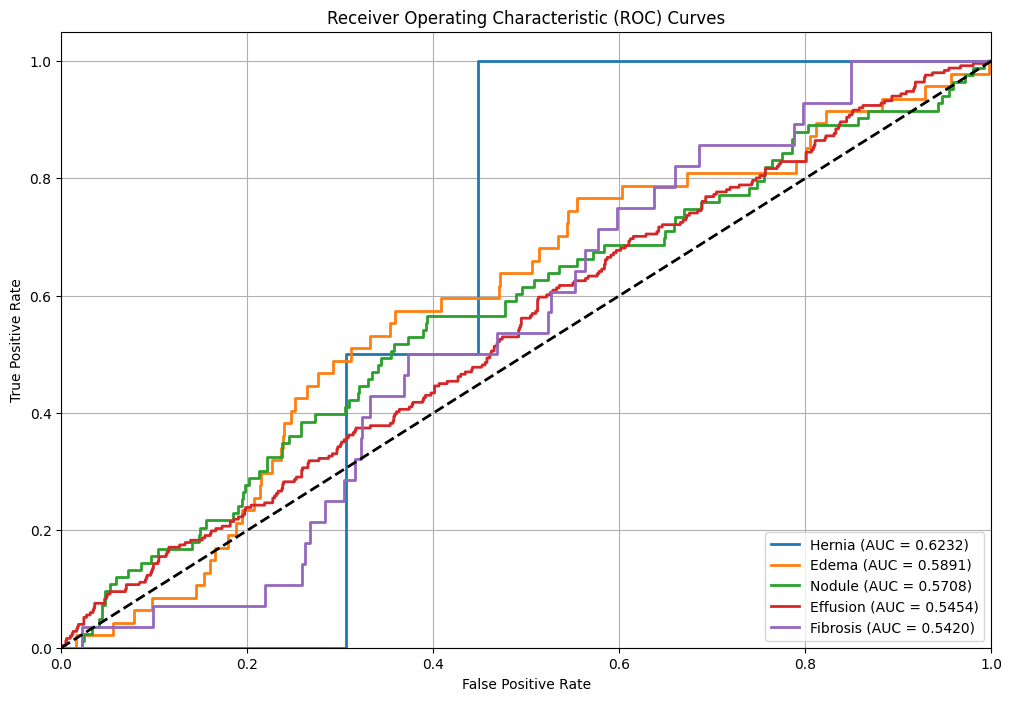

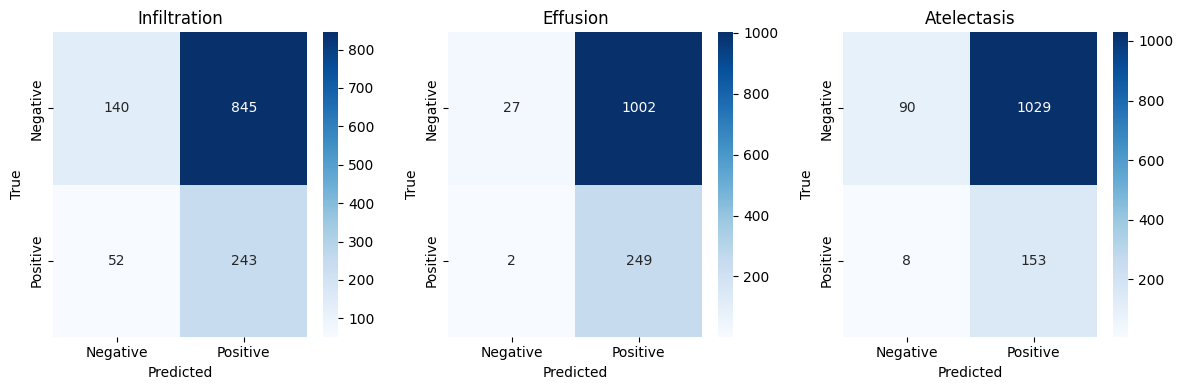

Generating GradCAM visualizations for model interpretability...
Using Conv2d as target layer for Grad-CAM


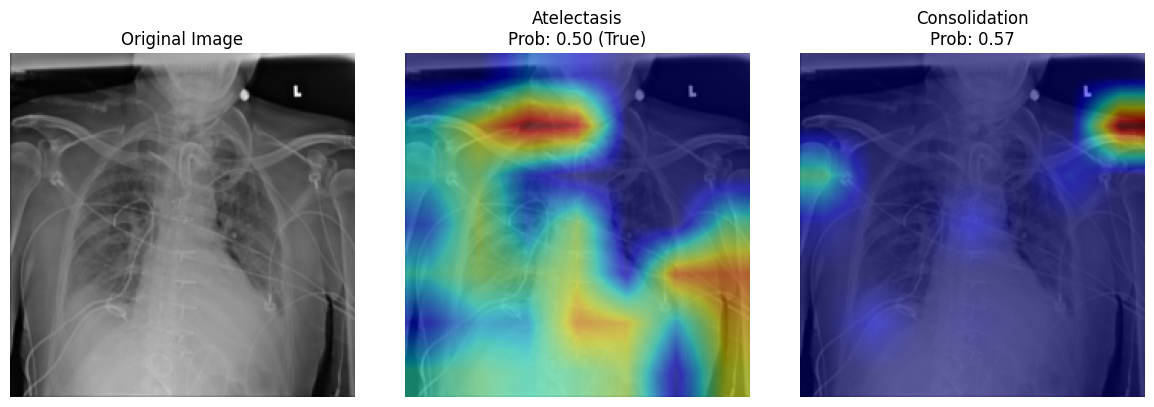

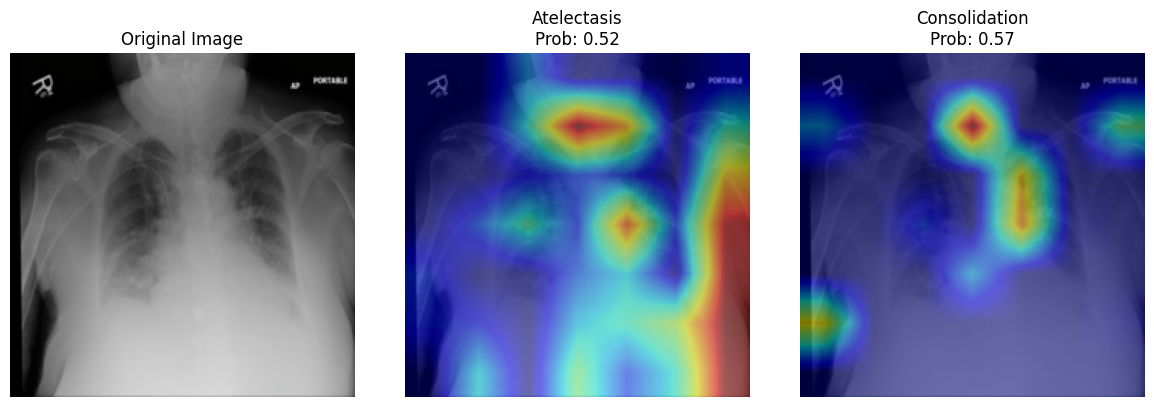


MODEL 2: SPECIALIZED CHEST X-RAY ATTENTION NETWORK
Creating ChestXrayAttentionNetwork...
Calculating class weights efficiently...
Class weights calculated in 0.00s
Using weighted BCE loss with class weights:
Atelectasis          8.5580
Consolidation        25.4122
Infiltration         5.2909
Pneumothorax         32.2692
Edema                66.8431
Emphysema            53.0625
Fibrosis             55.7213
Effusion             8.7191
Pneumonia            110.6129
Pleural_Thickening   36.6087
Cardiomegaly         48.4286
Nodule               18.0110
Mass                 22.5374
Hernia               690.9986
Using Adam optimizer with lr=0.0001, weight_decay=1e-05
Using ReduceLROnPlateau scheduler with patience=3, factor=0.1
Training ChestXrayAttentionNetwork...

Starting training for 2 epochs...
--------------------------------------------------
Epoch 1/2
------------------------------


  0%|          | 0/109 [00:00<?, ?it/s]

Train Loss: 1.4074, AUROC: 0.5055


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 1.4069, AUROC: 0.5176

Epoch 2/2
------------------------------


  0%|          | 0/109 [00:00<?, ?it/s]

Train Loss: 1.4770, AUROC: 0.4968


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 1.4038, AUROC: 0.4981

Training complete in 3m 48s
Best val AUROC: 0.5176 at epoch 1
Evaluating ChestXrayAttentionNetwork...

Evaluating model...


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]


Evaluation Loss: 1.8618
Mean AUROC: 0.5104 (0.511 (0.488-0.533))
Mean F1 Score: 0.1303 (0.130 (0.123-0.137))
Mean Precision: 0.0744 (0.074 (0.070-0.079))
Mean Recall: 0.7908 (0.791 (0.778-0.802))

Per-class metrics:
Class                AUROC      F1 Score   Precision  Recall    
------------------------------------------------------------
Atelectasis          0.5017     0.2255     0.1272     0.9938    
Consolidation        0.5340     0.1287     0.0688     1.0000    
Infiltration         0.4876     0.3658     0.2265     0.9492    
Pneumothorax         0.4436     0.2024     0.1136     0.9247    
Edema                0.5744     0.0709     0.0368     0.9362    
Emphysema            0.5381     0.0000     0.0000     0.0000    
Fibrosis             0.5258     0.0441     0.0225     1.0000    
Effusion             0.4746     0.3294     0.1972     1.0000    
Pneumonia            0.4702     0.0390     0.0199     0.9600    
Pleural_Thickening   0.5665     0.0915     0.0480     0.9672    
Cardiom

  0%|          | 0/109 [00:00<?, ?it/s]

Train Loss: 0.3770, AUROC: 0.4882


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.2004, AUROC: 0.5479

Epoch 2/2
------------------------------


  0%|          | 0/109 [00:00<?, ?it/s]

Train Loss: 0.1901, AUROC: 0.5077


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.1959, AUROC: 0.5351

Training complete in 3m 57s
Best val AUROC: 0.5479 at epoch 1
Performing specialized evaluation for rare and common diseases...


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Rare disease Hernia: AUROC=0.4225, F1=0.0000
Rare disease Pneumonia: AUROC=0.5469, F1=0.0000
Rare disease Edema: AUROC=0.5732, F1=0.0000

Rare Disease Model Performance Summary:

Rare Disease Categories:
AUROC: 0.5142
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000

Common Disease Categories:
AUROC: 0.5341
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000
Visualizing attention maps for rare diseases...
Generating attention visualization for Hernia...


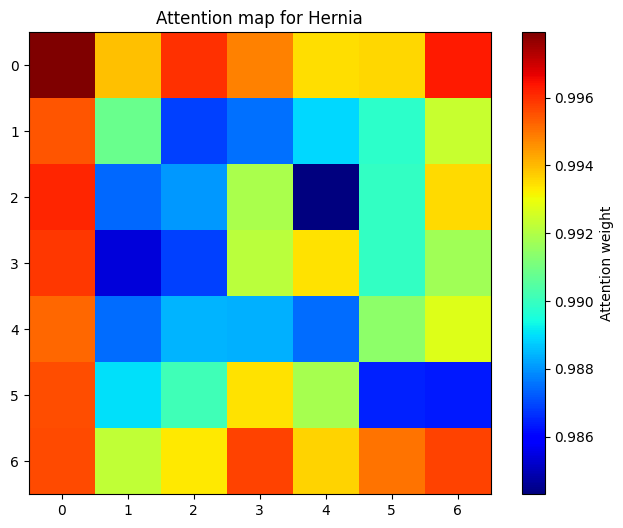

Generating attention visualization for Pneumonia...


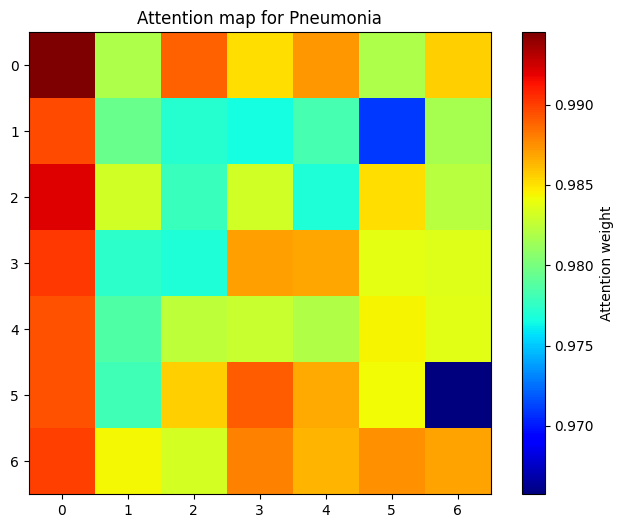


MODEL 4: ENSEMBLE MODEL
Creating ensemble with 3 models...
Evaluating ensemble model...


Evaluating ensemble:   0%|          | 0/40 [00:00<?, ?it/s]


Ensemble Test Loss: 0.3968
Ensemble AUROC: 0.5228
Ensemble F1 Score: 0.0000
Ensemble Precision: 0.0000
Ensemble Recall: 0.0000
Generating ROC curves for ensemble model...


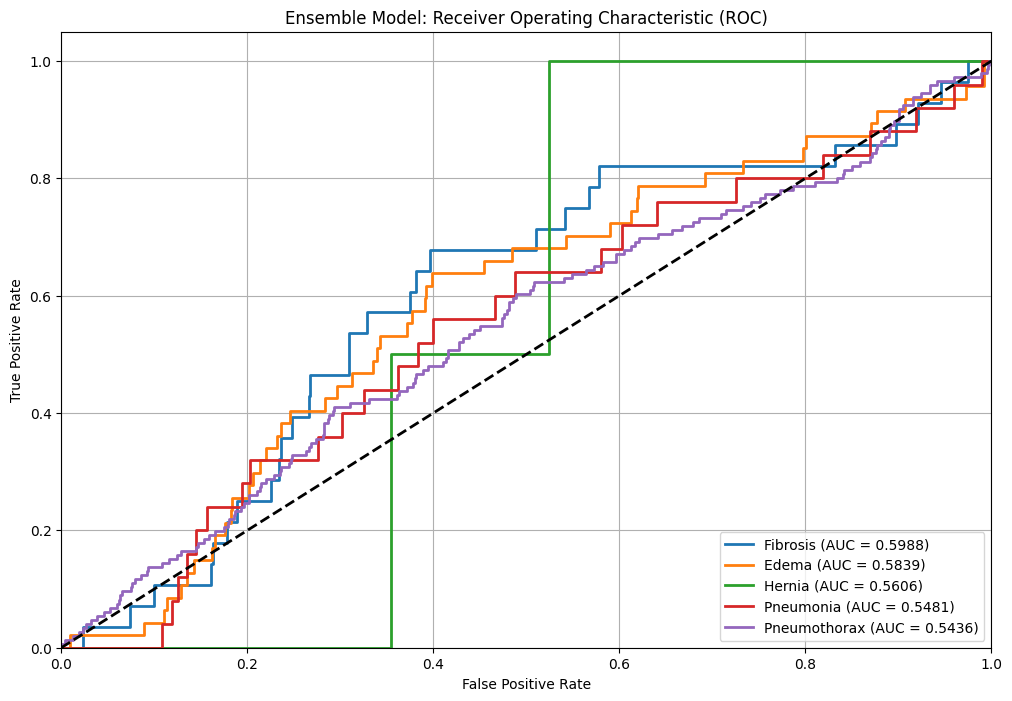


COMPREHENSIVE COMPARISON OF ALL ADVANCED MODELS

Model Performance Comparison:
------------------------------------------------------------------------------------------
Model                  AUROC      F1 Score   Precision  Recall     Notes                         
------------------------------------------------------------------------------------------
advanced_resnet        0.5149     0.0991     0.0714     0.4871                                   
chest_xray_attention   0.5104     0.1303     0.0744     0.7908                                   
rare_disease           0.5298     0.0000     0.0000     0.0000     Better on common diseases     
ensemble               0.5228     0.0000     0.0000     0.0000                                   

BEST MODEL: rare_disease
BEST AUROC: 0.5298

Generating comprehensive visualizations...


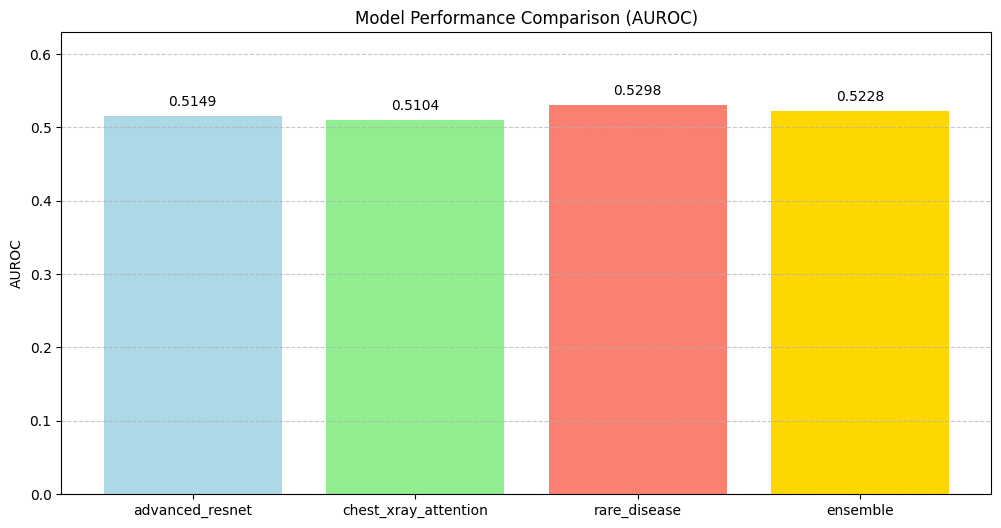

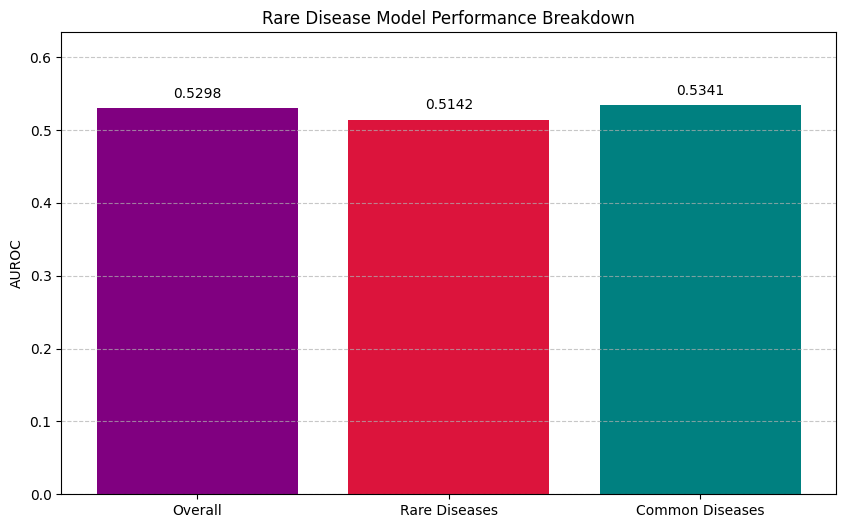


ENHANCED MODEL EVALUATION
Performing comprehensive evaluation on best model: rare_disease



COMPREHENSIVE MODEL EVALUATION REPORT

1. BASIC PERFORMANCE METRICS
------------------------------
Average AUROC: 0.5298
Average F1 Score: 0.0000
Average Precision: 0.0000
Average Recall: 0.0000

Top 5 Performing Classes (by AUROC):
Fibrosis: 0.6387
Pneumothorax: 0.6156
Edema: 0.5732
Pneumonia: 0.5469
Emphysema: 0.5440

2. DEMOGRAPHIC PERFORMANCE ANALYSIS
------------------------------

Performance by Gender:
M: AUROC = 0.5407 (n=642)
F: AUROC = 0.5311 (n=638)

Performance by View:
PA: AUROC = 0.5283 (n=844)
AP: AUROC = 0.5402 (n=436)

3. ERROR ANALYSIS
------------------------------
Classes with highest error rates:

False Negative Rate (missed diagnoses):
Atelectasis: 1.0000
Consolidation: 1.0000
Infiltration: 1.0000
Pneumothorax: 1.0000
Edema: 1.0000

False Positive Rate (incorrect diagnoses):
Atelectasis: 0.0000
Consolidation: 0.0000
Infiltration: 0.0000
Pneumothorax: 0.0000
Edema: 0.0000

Most Common Confusion Pairs:

4. CONCLUSION
------------------------------
Overall Model Ass

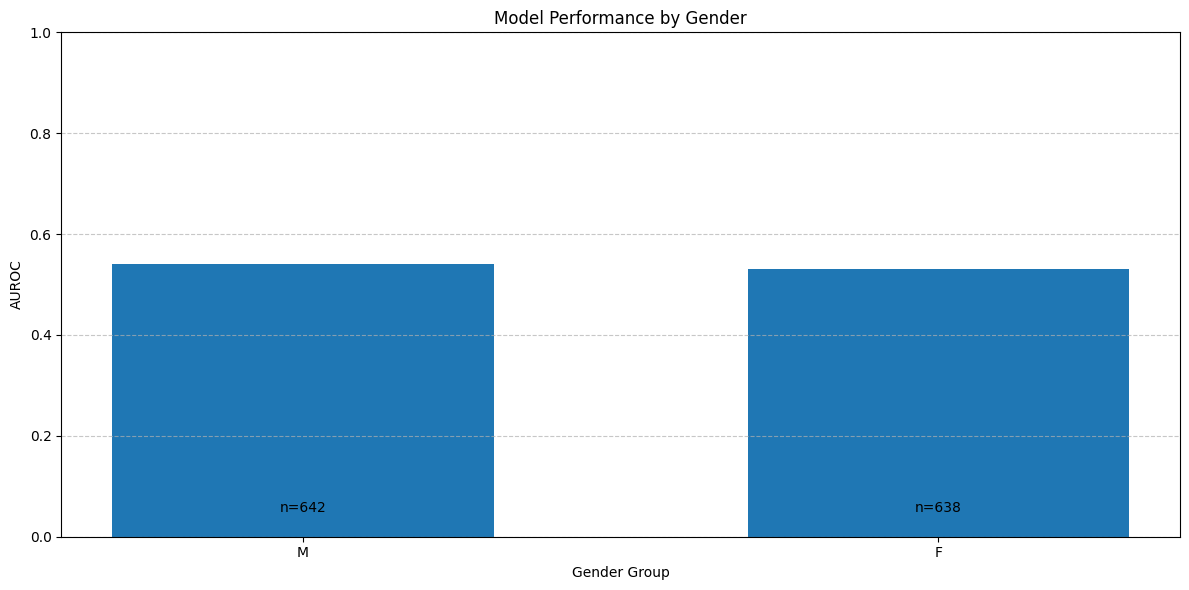


Performance by Gender:
M: AUROC = 0.5407 (n=642)
F: AUROC = 0.5311 (n=638)


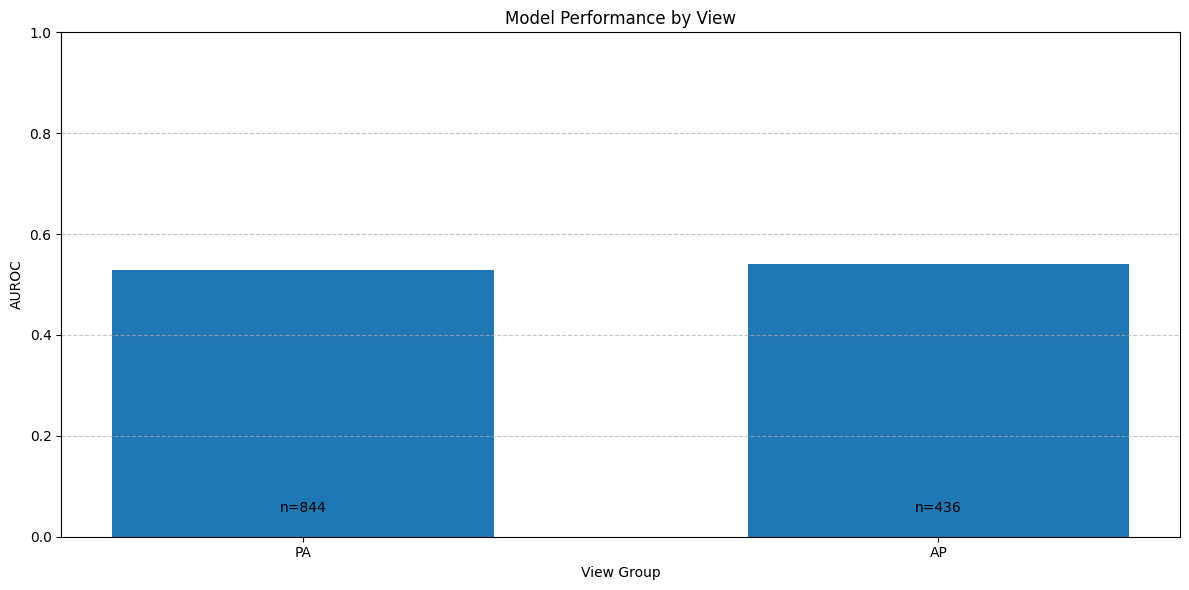


Performance by View:
PA: AUROC = 0.5283 (n=844)
AP: AUROC = 0.5402 (n=436)


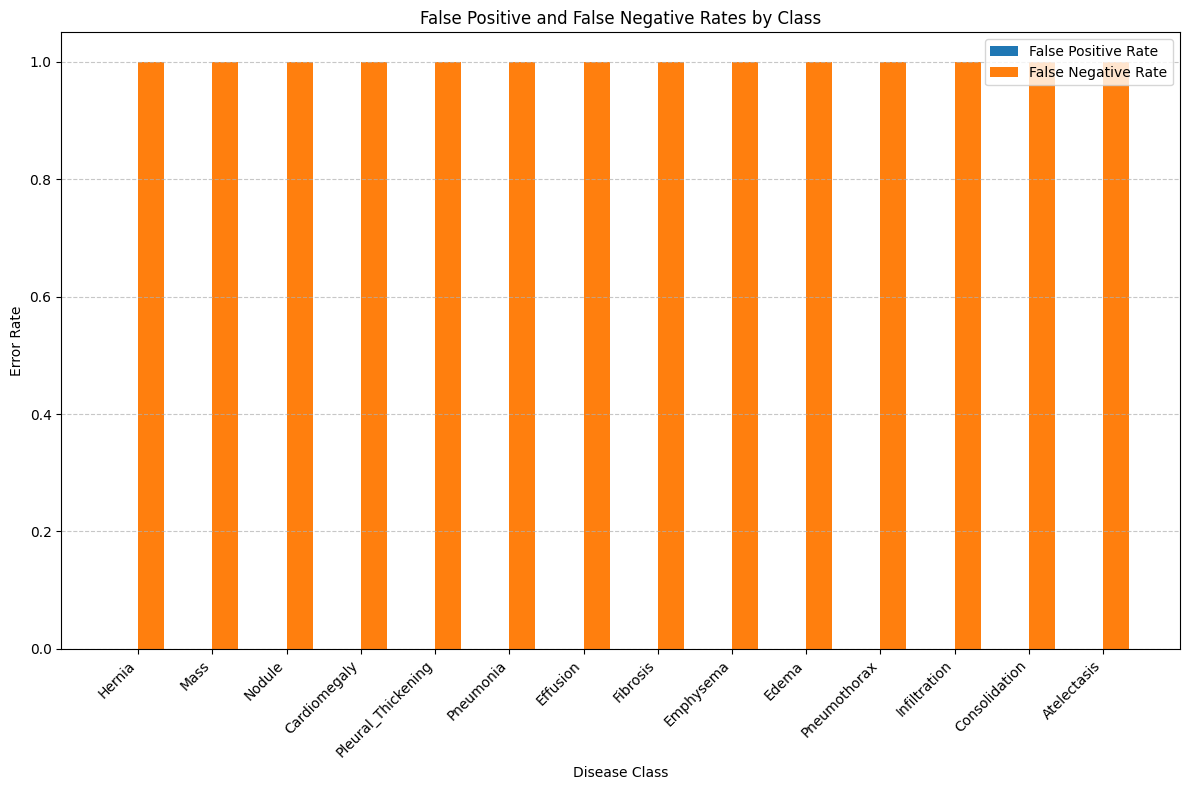


Classes with highest error rates:

False Negative Rate (missed diagnoses):
Hernia: 1.0000
Mass: 1.0000
Nodule: 1.0000
Cardiomegaly: 1.0000
Pleural_Thickening: 1.0000

False Positive Rate (incorrect diagnoses):
Atelectasis: 0.0000
Consolidation: 0.0000
Infiltration: 0.0000
Pneumothorax: 0.0000
Edema: 0.0000

Most Common Confusion Pairs:

ADVANCED CHEST X-RAY CLASSIFICATION PIPELINE COMPLETED SUCCESSFULLY

COMPLETED EXECUTION - BEST MODEL: rare_disease


In [13]:
if __name__ == "__main__":
    # Create output directories first
    create_output_directories()
    
    # Configuration setup
    config = Config()
    config.num_epochs = 2  # Set to low value for faster execution
    config.sampling_rate = 0.05  # Use 5% of data for demonstration
    config.display()
    
    # Execute the main pipeline
    best_model, all_results = main()
    
    print("\n" + "="*70)
    print(f"COMPLETED EXECUTION - BEST MODEL: {best_model}")
    print("="*35)